![electronic_music_by_genre.jpg](./electronic_music_by_genre.jpg)

In [172]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bootcampviztools as bt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif,SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import os
from IPython.display import display, Image
import sys

from scipy.stats import f_oneway

# 1. Carga datos

In [2]:
#Cargo el dataset
df = pd.read_csv('./beatsdataset_full.csv')

In [3]:
#Echo un primer vistazo
df.head()


Unnamed: 0    1-ZCRm  2-Energym  3-EnergyEntropym  4-SpectralCentroidm  \
0           0  0.136402   0.088891          3.201238             0.262813   
1           1  0.117053   0.108397          3.194091             0.247679   
2           2  0.085314   0.128537          3.123835             0.217220   
3           3  0.103046   0.167006          3.151050             0.233638   
4           4  0.151702   0.148412          3.194361             0.293711   

   5-SpectralSpreadm  6-SpectralEntropym  7-SpectralFluxm  8-SpectralRolloffm  \
0           0.249214            1.114200         0.007004            0.256620   
1           0.250297            1.065840         0.005388            0.199849   
2           0.228655            0.789821         0.008251            0.156863   
3           0.245044            0.967372         0.006569            0.168171   
4           0.267226            1.352688         0.003874            0.291922   

   9-MFCCs1m  ...  85-beats_loudness_band_ratio.mean5  \
0 -22.723397  ...                            0.053618   
1 -21.775519  ...                            0.077255   
2 -22.472499  ...                            0.052989   
3 -21.471472  ...                            0.059995   
4 -21.371298  ...                            0.062124   

   86-beats_loudness_band_ratio.mean6  87-beats_loudness_band_ratio.stdev1  \
0                            0.060700                             0.361006   
1                            0.070787                             0.345560   
2                            0.064381                             0.250985   
3                            0.046833                             0.316349   
4                            0.093716                             0.316923   

   88-beats_loudness_band_ratio.stdev2  89-beats_loudness_band_ratio.stdev3  \
0                             0.229552                             0.260985   
1                             0.106581                             0.198952   
2                             0.148319                             0.094546   
3                             0.119784                             0.092762   
4                             0.087055                             0.139083   

   90-beats_loudness_band_ratio.stdev4  91-beats_loudness_band_ratio.stdev5  \
0                             0.145522                             0.078291   
1                             0.095644                             0.100741   
2                             0.085440                             0.039289   
3                             0.110708                             0.079089   
4                             0.095219                             0.071245   

   92-beats_loudness_band_ratio.stdev6    class              id  
0                             0.082724  BigRoom  BigRoom001.wav  
1                             0.072654  BigRoom  BigRoom002.wav  
2                             0.062705  BigRoom  BigRoom003.wav  
3                             0.061871  BigRoom  BigRoom004.wav  
4                             0.095066  BigRoom  BigRoom005.wav  

[5 rows x 95 columns]

In [4]:
#Elimino las columnas que no me aportan nada

df.drop('id', axis = 1, inplace=True)
df.drop('Unnamed: 0', axis = 1, inplace=True)

# 2. Problema Machine Learning
Me encuentro frente a un problema de aprendizaje supervisado ya que cuento con datos etiquetados por genero. Me encuentro con un dataset con 95 variables y 2300 instancias. Donde cada instancia es un sample de 2 minutos de audio de 100 canciones por genero, del BeatportTop100 (Un canal de streaming y compra de canciones de musica electrónica), analizado técnicamente.

# 3. Divido en Train y Test

In [5]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
train_set.shape

(1840, 93)

In [7]:
test_set.shape

(460, 93)

# 4. Target

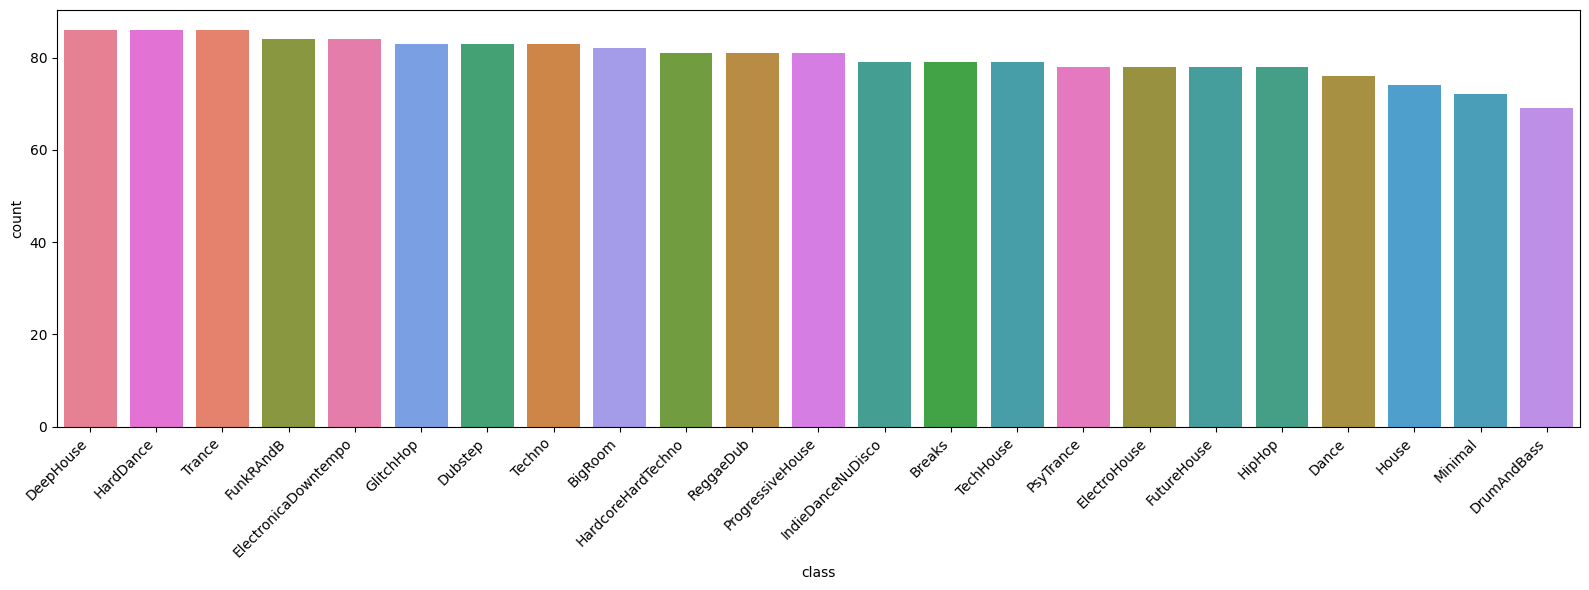

In [8]:
#Defino el target
target = 'class'

# Analizo el target
plt.figure(figsize=(16, 6))
sns.countplot(data=train_set, x=target, order=train_set[target].value_counts().index, legend = False, hue = target)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Veo que me enfrento a un problema con un target balanceado y con muchisimas clases, en el EDA pasaréa agruparlas en su género principal.

# 5. Comprensión de variables

In [9]:
#Miro de que tipo son los datos que dispongo

train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1840 entries, 360 to 860
Data columns (total 93 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   1-ZCRm                               1840 non-null   float64
 1   2-Energym                            1840 non-null   float64
 2   3-EnergyEntropym                     1840 non-null   float64
 3   4-SpectralCentroidm                  1840 non-null   float64
 4   5-SpectralSpreadm                    1840 non-null   float64
 5   6-SpectralEntropym                   1840 non-null   float64
 6   7-SpectralFluxm                      1840 non-null   float64
 7   8-SpectralRolloffm                   1840 non-null   float64
 8   9-MFCCs1m                            1840 non-null   float64
 9   10-MFCCs2m                           1840 non-null   float64
 10  11-MFCCs3m                           1840 non-null   float64
 11  12-MFCCs4m                        

Es un dataset con datos numericos, cada columna son features de audio extraidas y analizadas de una muestra aleatoria de 2 minutos sobre cada cancion.

In [10]:
#Fuerzo el tipo de dato del que dispongo para evitar errores posteriores

new_types = {
    float: [col for col in train_set.columns if col != 'class'],
    str: ['class'],
}

for key, value in new_types.items():
    for i in value:
        train_set[i] = train_set[i].astype(key)

#### Reporte de variables
Un pequeño reporte que incluye las características de las variables: el nombre, el tipo de dato, a que segmento se refiere la información, las expectativas de mantener la variable y con un detalle de por qué, y la conclusión preliminar.

In [11]:
feature_report = pd.read_excel('./analisis_variables_audio.xlsx')
feature_report

Variable  \
0                                1-ZCRm   
1                             2-Energym   
2                      3-EnergyEntropym   
3                   4-SpectralCentroidm   
4                     5-SpectralSpreadm   
..                                  ...   
87  88-beats_loudness_band_ratio.stdev2   
88  89-beats_loudness_band_ratio.stdev3   
89  90-beats_loudness_band_ratio.stdev4   
90  91-beats_loudness_band_ratio.stdev5   
91  92-beats_loudness_band_ratio.stdev6   

                                              Detalle              Data type  \
0   Zero Crossing Rate (media): cantidad de veces ...  cuantitativa continua   
1   Energy (media): energía total de la señal. Rel...  cuantitativa continua   
2   Energy Entropy (media): mide la variabilidad d...  cuantitativa continua   
3   Centroide espectral (media): indica el "centro...  cuantitativa continua   
4   Dispersión espectral (media): medida de cuán e...  cuantitativa continua   
..                                                ...                    ...   
87  Beat loudness 1 a 6 (desvío estándar): Energía...  cuantitativa continua   
88  Beat loudness 1 a 6 (desvío estándar): Energía...  cuantitativa continua   
89  Beat loudness 1 a 6 (desvío estándar): Energía...  cuantitativa continua   
90  Beat loudness 1 a 6 (desvío estándar): Energía...  cuantitativa continua   
91  Beat loudness 1 a 6 (desvío estándar): Energía...  cuantitativa continua   

                           Segmento Expectativas  \
0                 Espectral/Energía         Alta   
1                 Espectral/Energía         Alta   
2                 Espectral/Energía         Alta   
3                 Espectral/Energía         Alta   
4                 Espectral/Energía         Alta   
..                              ...          ...   
87  Banda de Frecuencias / Loudness        Media   
88  Banda de Frecuencias / Loudness        Media   
89  Banda de Frecuencias / Loudness        Media   
90  Banda de Frecuencias / Loudness        Media   
91  Banda de Frecuencias / Loudness        Media   

                                    Conclusiones  
0                     Probablemente se mantendrá  
1                     Probablemente se mantendrá  
2                     Probablemente se mantendrá  
3                     Probablemente se mantendrá  
4                     Probablemente se mantendrá  
..                                           ...  
87  Podría mantenerse si no hay alta correlación  
88  Podría mantenerse si no hay alta correlación  
89  Podría mantenerse si no hay alta correlación  
90  Podría mantenerse si no hay alta correlación  
91  Podría mantenerse si no hay alta correlación  

[92 rows x 6 columns]

De este reporte, obtengo una primera separacion entre las expectativas que tengo de cada variable. Divido en alta, media y bajas o inciertas expectativas de quedarme con esta variable. Describo el tipo de variable, a que se estan refiriendo y detallo por que serian o no importante y que conclusion inicial puedo obtener. Al ser informacion tecnica de un sample de audio, entiendo que varias variables van a ser redundantes, me van a aportar la misma informacion. Incluso ya viendo los nombres y viendo que parecerian indicar caracteristicas similares de la misma cosa, puedo llegar a imaginarme que seran redundantes. Analizare en profundidad su colinealidad.

Hago una lista de estas variables con expectativas altas

In [12]:
features_altas_expectativas = feature_report.loc[feature_report['Expectativas'] == 'Alta', 'Variable'].tolist()
features_altas_expectativas

['1-ZCRm',
 '2-Energym',
 '3-EnergyEntropym',
 '4-SpectralCentroidm',
 '5-SpectralSpreadm',
 '6-SpectralEntropym',
 '7-SpectralFluxm',
 '8-SpectralRolloffm',
 '9-MFCCs1m',
 '22-ChromaVector1m',
 '43-MFCCs1std',
 '56-ChromaVector1std',
 '69-BPM',
 '70-BPMconf',
 '71-BPMessentia',
 '77-danceability']

# EDA

##### Preguntas

1. ¿Es el House el género más bailable?
2. ¿Qué género musical presenta mayor energía o intensidad percibida?
3. ¿La música electrónica es puro ruido?
4. ¿Qué variable es la más relevante para diferenciar géneros musicales?
5. ¿No se puede bailar el techno?

##### Análisis

Siguiendo la siguiente imagen, utilizaremos los géneros madre para agrupar los subgéneros y así simplificar el análisis visual y gráfico del EDA.

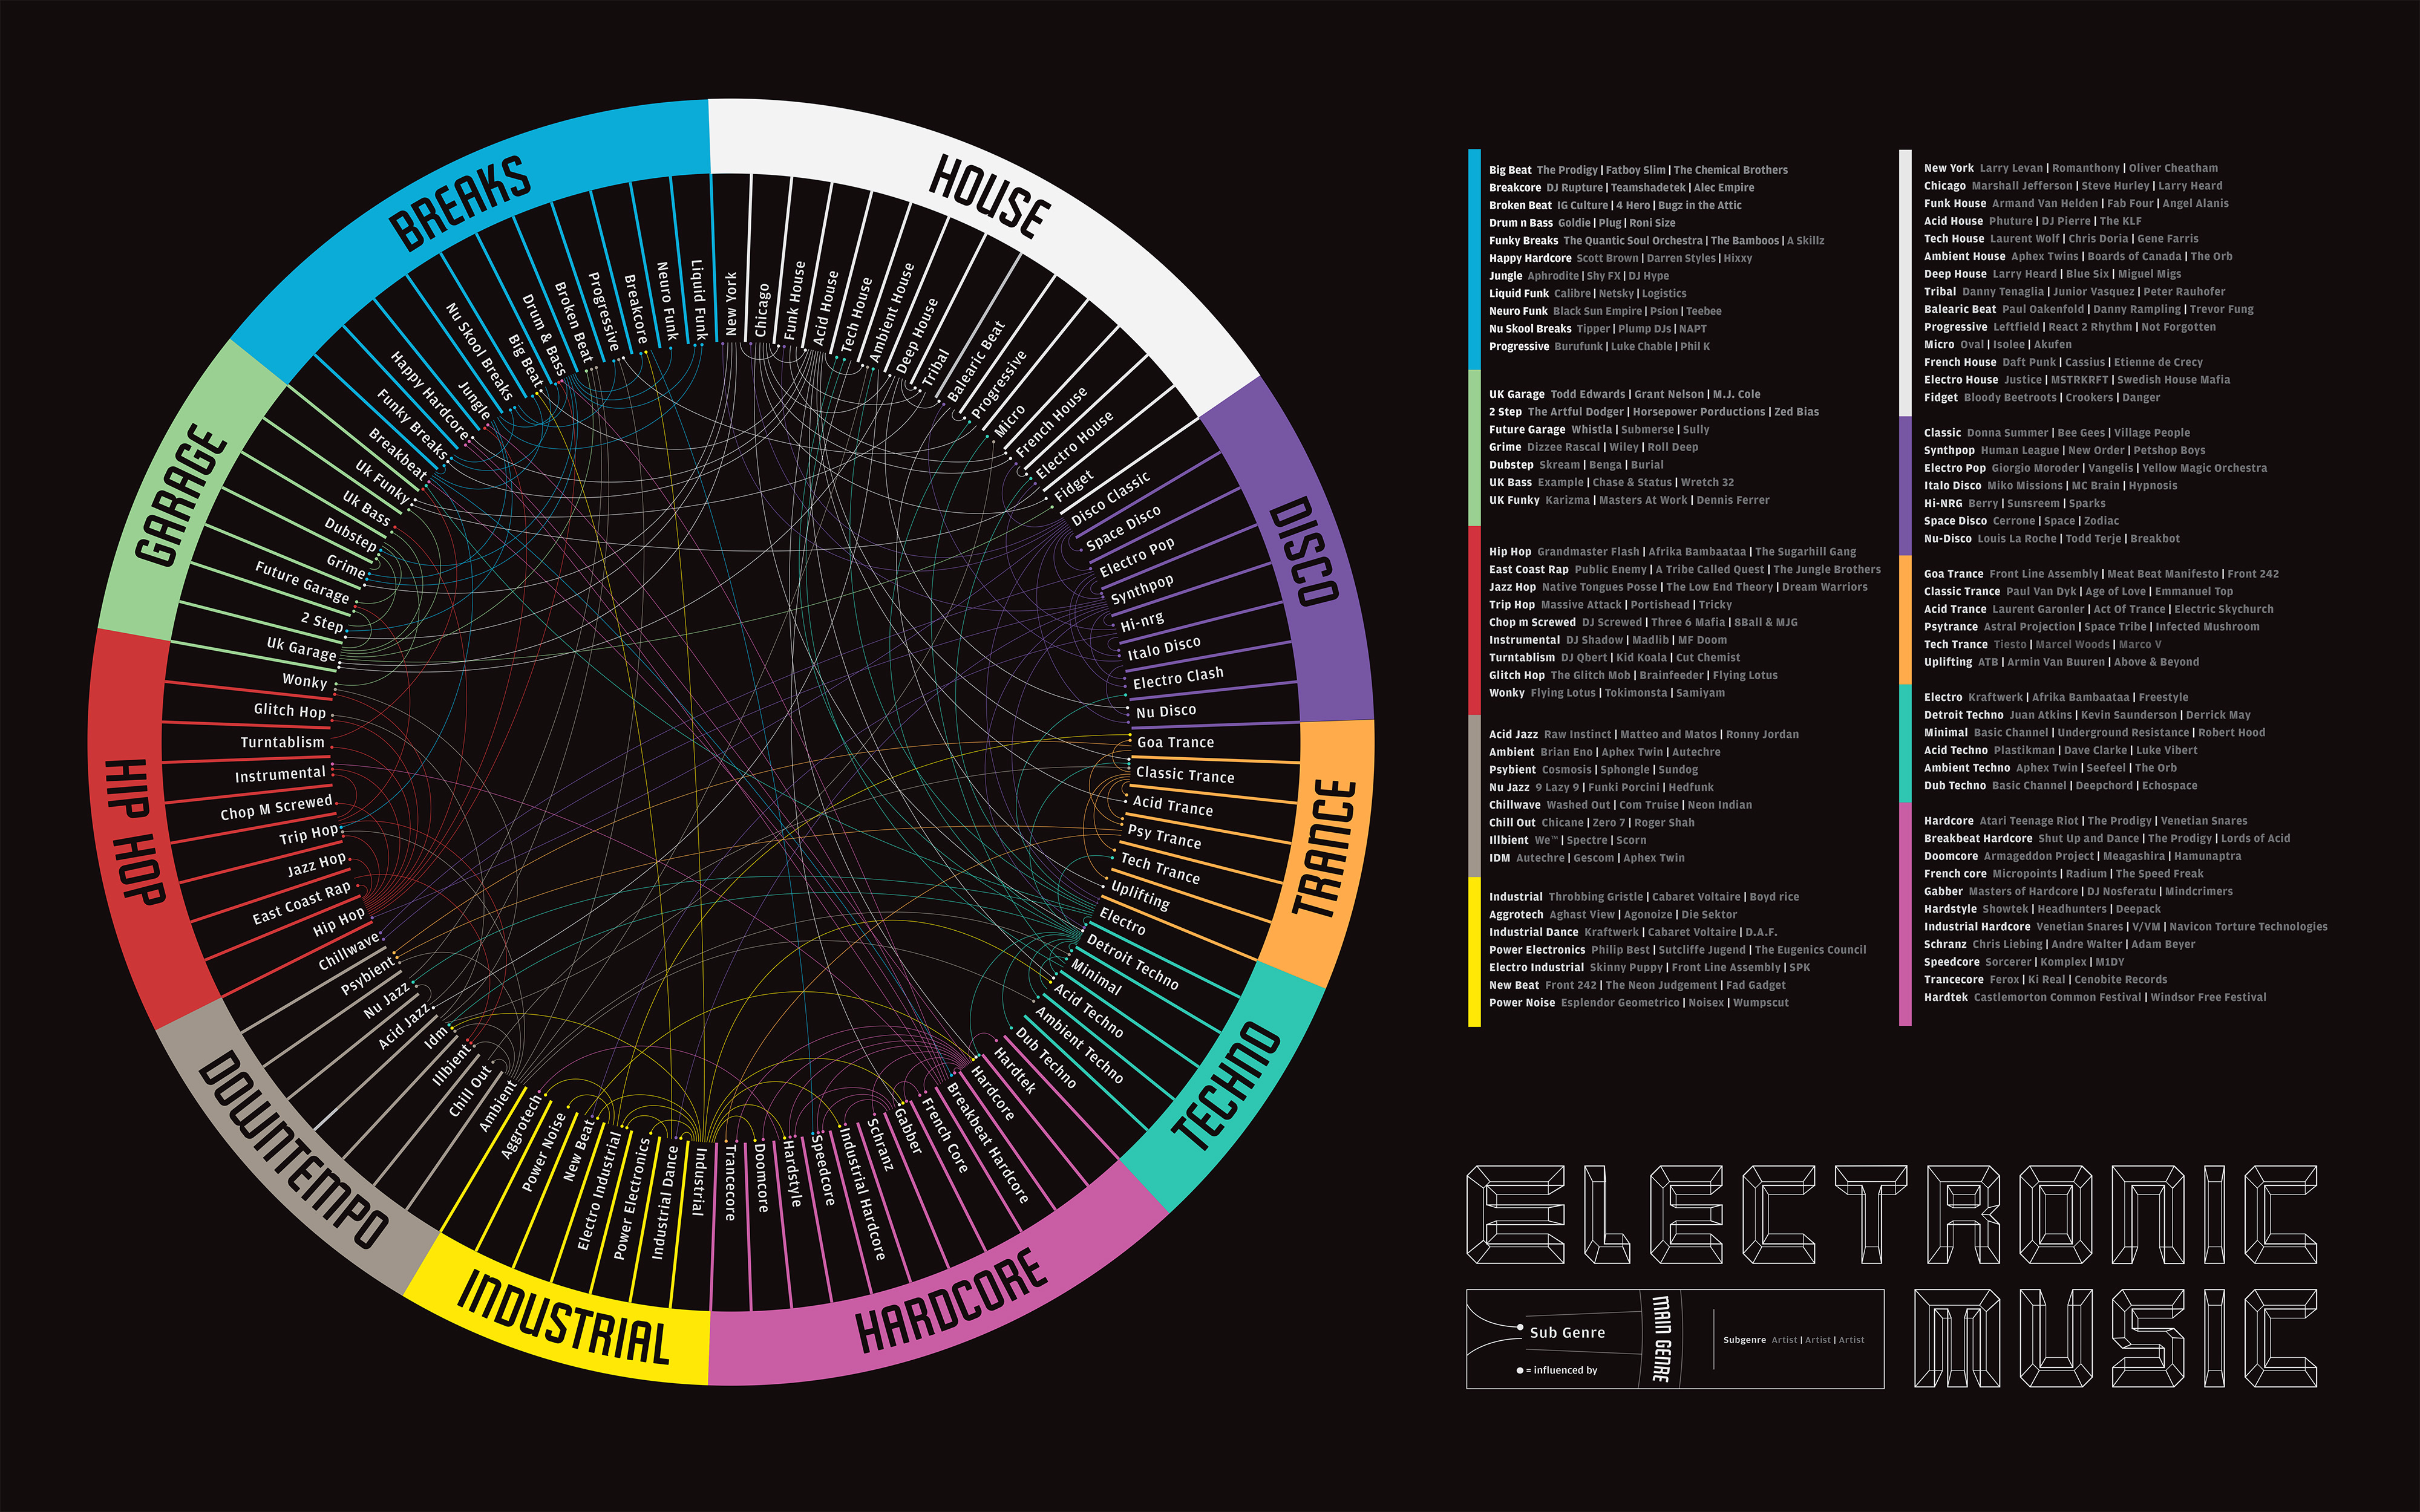

In [13]:
img = './electronic_music_by_genre.jpg'
display(Image(filename=img))

In [14]:
train_set[target].value_counts()

class
DeepHouse               86
HardDance               86
Trance                  86
FunkRAndB               84
ElectronicaDowntempo    84
GlitchHop               83
Dubstep                 83
Techno                  83
BigRoom                 82
HardcoreHardTechno      81
ReggaeDub               81
ProgressiveHouse        81
IndieDanceNuDisco       79
Breaks                  79
TechHouse               79
PsyTrance               78
ElectroHouse            78
FutureHouse             78
HipHop                  78
Dance                   76
House                   74
Minimal                 72
DrumAndBass             69
Name: count, dtype: int64

In [ ]:
new_classes = {'DeepHouse': 'House',
               'ProgressiveHouse': 'House',
               'TechHouse': 'House',
               'PsyTrance': 'Trance',
               'HardDance': 'Hardcore',
               'FunkRAndB': 'Urban',
                'ElectronicaDowntempo': 'Downtempo',
                'GlitchHop': 'HipHop',
                'Dubstep': 'Garage',
                'BigRoom': 'House',
                'HardcoreHardTechno': 'Hardcore',
                'ReggaeDub': 'Alternative',
                'IndieDanceNuDisco': 'Disco',
                'ElectroHouse': 'House',
                'FutureHouse': 'House',
                'DrumAndBass': 'Breaks',
                'Minimal': 'Techno',
                'Dance': 'House',
                'Hardcore': 'Techno',
                'HipHop': 'Urban',
                'Breaks': 'Urban'}

In [21]:
train_set['new_target'] = train_set[target].replace(new_classes)

In [149]:
train_set['new_target'] = train_set['new_target'].replace({'HipHop': 'Urban', 'Breaks': 'Urban', 'Hardcore': 'Techno'})

In [150]:
train_set['new_target'].value_counts()

new_target
House        634
Urban        474
Techno       322
Trance       164
Downtempo     84
Garage        83
Disco         79
Name: count, dtype: int64

In [30]:
target = 'new_target'

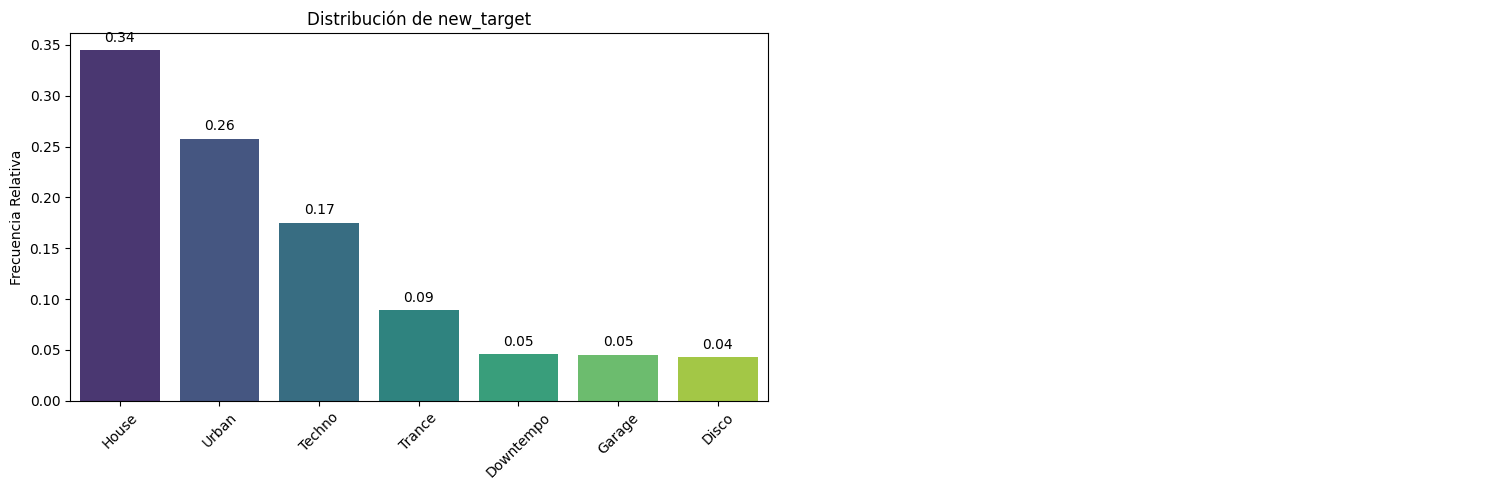

In [31]:
#Analizo el target
bt.pinta_distribucion_categoricas(train_set, columnas_categoricas=[target], mostrar_valores=True, relativa=True)

Vemos como al agrupar los subgéneros obtenemos un target desbalanceado, luego utilizaremos las herramientas necesarias para equilibrarlo

In [32]:
#### Busco si hay valores nulos o valores 0 en las columnas
for col in train_set.columns:
    nulos = train_set[col].isnull().sum()
    ceros = (train_set[col] == 0).sum() if train_set[col].dtype != 'O' else 0
    if nulos > 0 or ceros > 0:
        print(f"Columna '{col}': {nulos} nulos, {ceros} ceros")

Columna '73-bpm_histogram_first_peak_weight': 0 nulos, 42 ceros
Columna '74-bpm_histogram_second_peak_bpm': 0 nulos, 125 ceros
Columna '75-bpm_histogram_second_peak_spread': 0 nulos, 768 ceros
Columna '76-bpm_histogram_second_peak_weight': 0 nulos, 125 ceros


Contexto de negocio para estas columnas:
Estas columnas son  derivadas de un análisis de histograma del tempo (BPM). Usualmente, en audio: el primer pico se refiere al BPM más probable.
El segundo pico representa un BPM alternativo, si existe.
Esto sugiere que cuando el segundo pico no existe (no se detecta otro BPM relevante), es esperado que second_peak_bpm, second_peak_weight, etc. sean 0.
Así que no son valores faltantes, sino ausencia legítima de una segunda modalidad en el histograma. Justo estas columnas son las columnas que apriori estan etiquetadas con una baja expectativa de mantenerlas.

Analizo primero las 3 variables que hacen referencia al tempo

In [33]:
train_set['69-BPM'].value_counts()

69-BPM
120.000000    658
133.333333    494
150.000000    189
171.428571    159
240.000000    116
200.000000     99
109.090909     53
300.000000     41
100.000000     12
400.000000      7
92.307692       4
600.000000      3
85.714286       3
63.157895       1
80.000000       1
Name: count, dtype: int64

In [34]:
train_set['70-BPMconf'].value_counts()

70-BPMconf
0.113648    3
0.168038    2
0.293719    2
0.200000    2
0.103385    2
           ..
0.114948    1
0.192281    1
0.161808    1
0.119306    1
0.149327    1
Name: count, Length: 1830, dtype: int64

In [35]:
train_set['71-BPMessentia'].value_counts()

71-BPMessentia
172.265961    5
172.265839    4
128.020706    3
128.096390    2
123.981453    2
             ..
125.933182    1
128.093826    1
139.801910    1
128.238403    1
111.970833    1
Name: count, Length: 1806, dtype: int64

Luego de revisar los valores para cada variable, me doy cuenta de que los valores de '69-BPM' no me hacen sentido conociendo el negocio. Esta columna me doy cuenta de que tiene valores muy discretos y repetidos, y valores extremos como 300, 400 o 600. No parecen mediciones exactas sino valores normalizados o redondeados automaticamente. Y luego al analizar los valores de la columna '71-BPMessentia' me doy cuenta de que esta es la que contiene la informacion real, medida por Essentia, una librería especializada en análisis de audio. Entonces decido utilizar la feature '71-BPMessentia' como mi variable principal de tempo y elimino la variable '69-BPM' que se a ciencia exacta que no colabora con mi modelo y '70-BPMconf' se refiere a la confianza en la variable '69-BPM, la descarto tambien

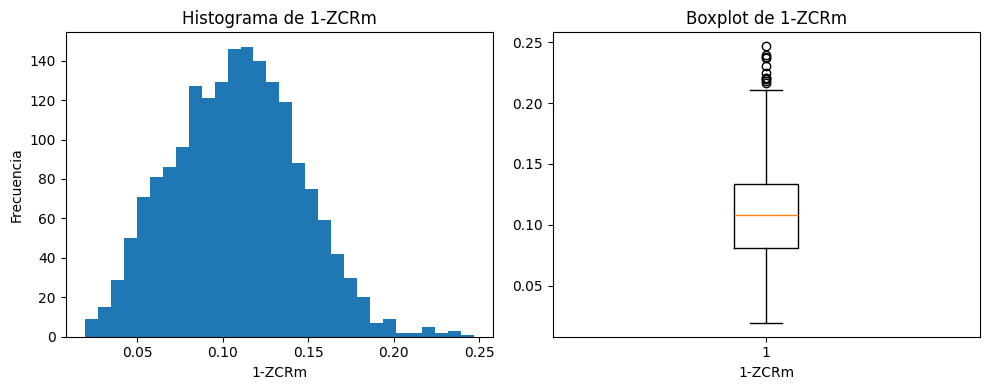

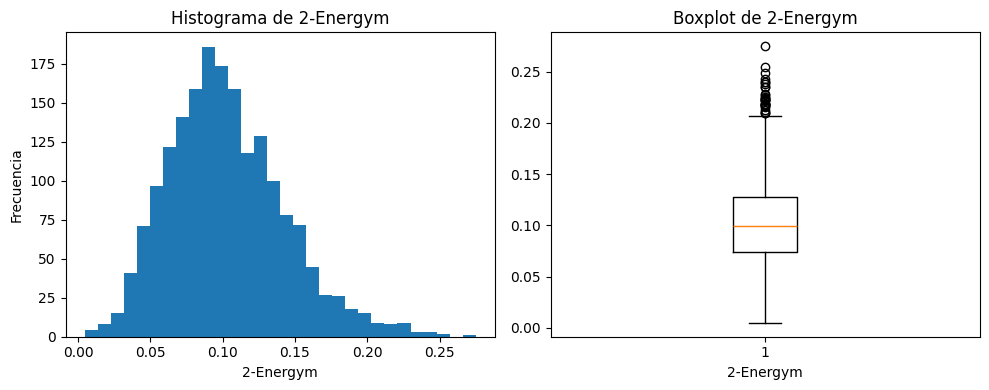

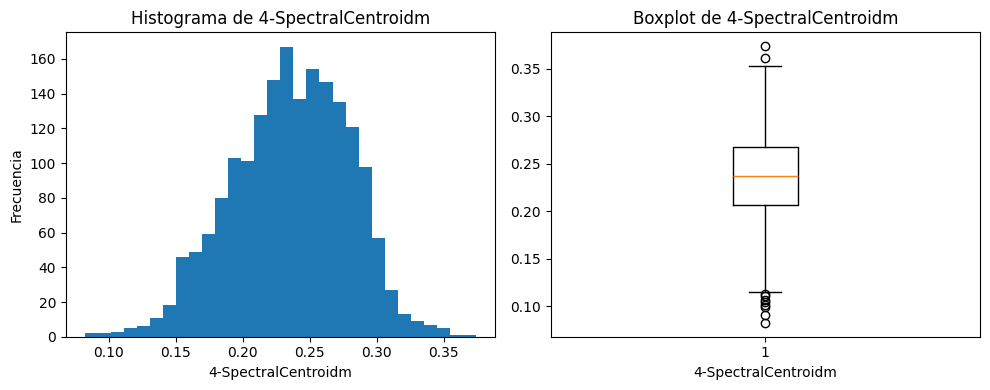

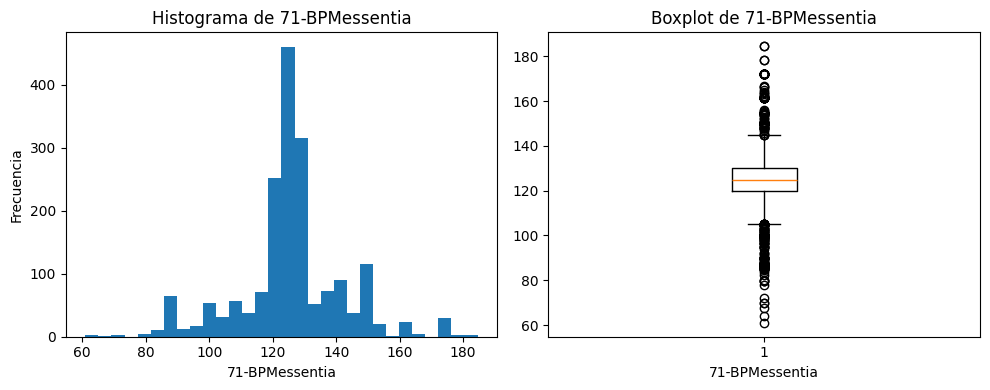

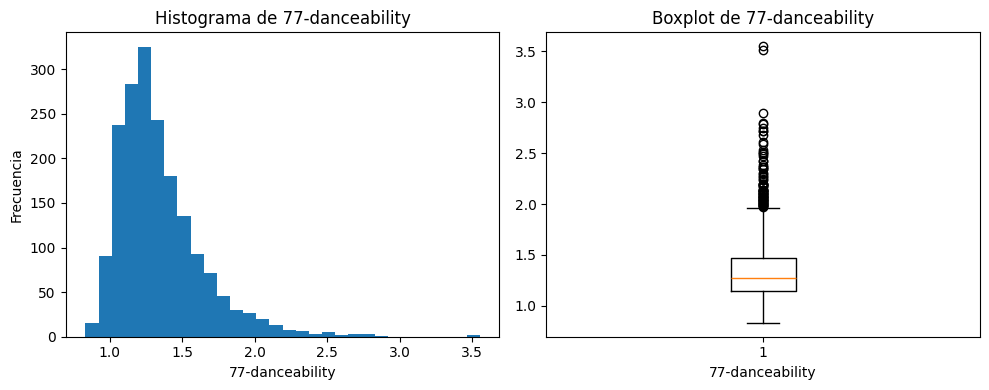

In [36]:
# Seleccionar algunas variables representativas para visualización
selected_columns = [
    '1-ZCRm',             # Zero Crossing Rate media
    '2-Energym',          # Energía media
    '4-SpectralCentroidm',# Centroide espectral medio
    '71-BPMessentia',     # Beats por minuto
    '77-danceability'     # Bailabilidad
]

# Crear histogramas y boxplots para cada variable
for col in selected_columns:
    plt.figure(figsize=(10, 4))

    # Histograma
    plt.subplot(1, 2, 1)
    plt.hist(train_set[col], bins=30)
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")

    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(train_set[col])
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

Al hacer una búsqueda visual de un primer set de variables importantes, me ecuentro con que todas son informativas y me encuentro con multiples outliers en 77-danceability y BPMessentia. Voy a buscar a que géneros pertenecen, estimo que a géneros más intensos.

In [38]:
train_set.loc[train_set['77-danceability']>2]['new_target'].value_counts()

new_target
House        19
Disco        18
Urban        17
Downtempo     8
Techno        7
Name: count, dtype: int64

Valores altos (~3 o más) indican que el tema tiene: Un patrón rítmico muy regular, un alto grado de repetitividad y beats bien definidos. Aunque, la variable combina el tempo, la energia y la estabilidad rítmica, todas características expresadas por otras variables. Luego cuando analice la correlación, evaluaré su importancia. 

EL BPM represente el tempo de la canción, es normal que haya Outliers, ya que este valor es muy amplio, puede ir desde 60 a 240 dependiendo del género.

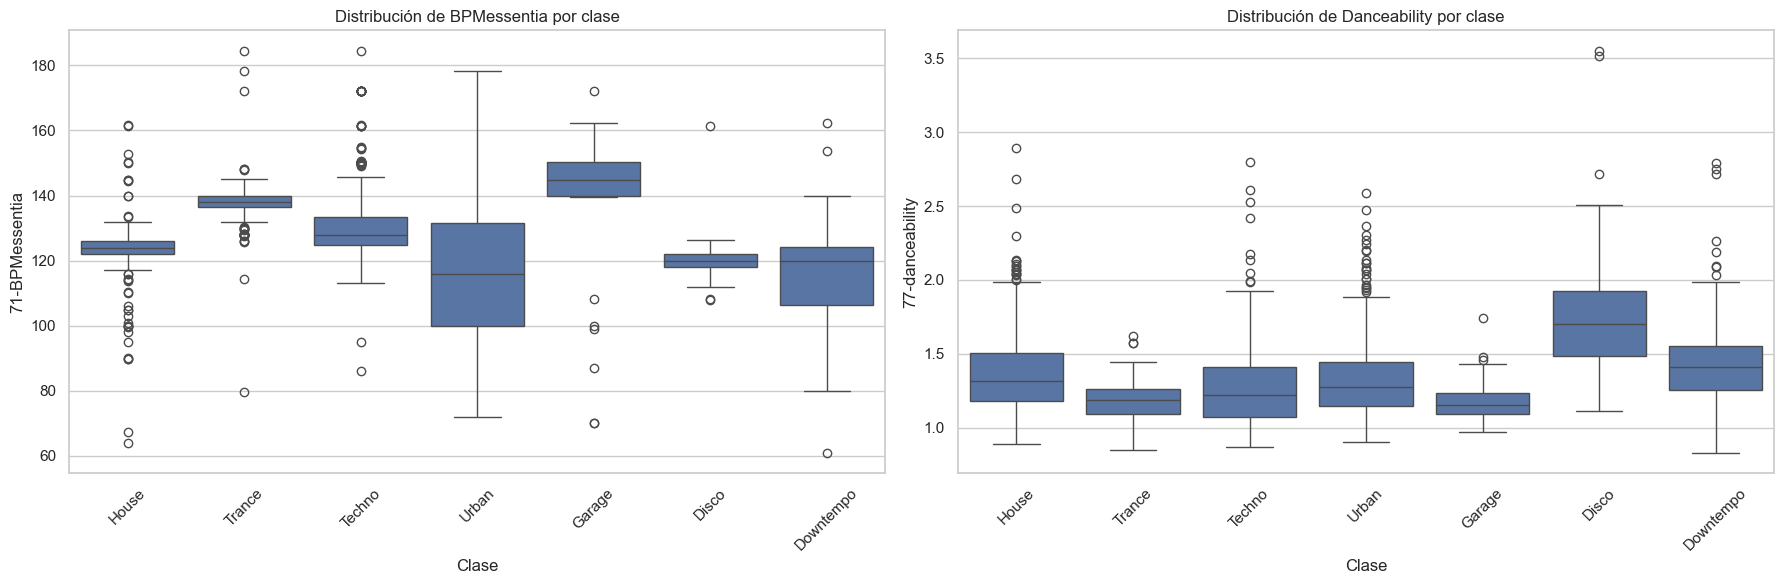

In [40]:
# Establecer estilo de gráfico
sns.set(style="whitegrid")

# Crear boxplots de BPMessentia y danceability por clase
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# BPMessentia por clase
sns.boxplot(data=train_set, x='new_target', y='71-BPMessentia', ax=axes[0])
axes[0].set_title("Distribución de BPMessentia por clase")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("71-BPMessentia")
axes[0].tick_params(axis='x', rotation=45)

# Danceability por clase
sns.boxplot(data=train_set, x='new_target', y='77-danceability', ax=axes[1])
axes[1].set_title("Distribución de Danceability por clase")
axes[1].set_xlabel("Clase")
axes[1].set_ylabel("77-danceability")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Observaciones para 'BPMessentia':

- Trance y Techno: tienen BPM altos y consistentes (medianas cerca de 135-140), con poca variabilidad, géneros rápidos y estables.
- Garage y House: también muestran BPM altos, pero con más dispersión en House.
- Urban: tiene una mediana más baja (~110) y una distribución más amplia, reflejando la diversidad del género (incluye HipHop, Funk, Reggae...).
- Downtempo: BPM significativamente más bajo (~100), como es esperable.
- Disco: mediana algo menor que House, pero menos variable.

71-BPMessentia es altamente discriminante por clase. Podría ser muy útil para clasificación basada en tempo.

Oservaciones para 'danceability':

- Disco y Downtempo tienen las medianas más altas en bailabilidad,patrones rítmicos más predecibles o repetitivos.
- Urban muestra alta dispersión, probablemente por la mezcla de estilos dentro de esta clase.
- Trance y Techno tienen valores de danceability más bajos en promedio, pese a su ritmo acelerado (esto es coherente: rápido no siempre es bailable).
- Garage tiene valores más bajos y menos dispersión.

Muestra tendendias que pueden ayudarme a difenrenciar los grupos.

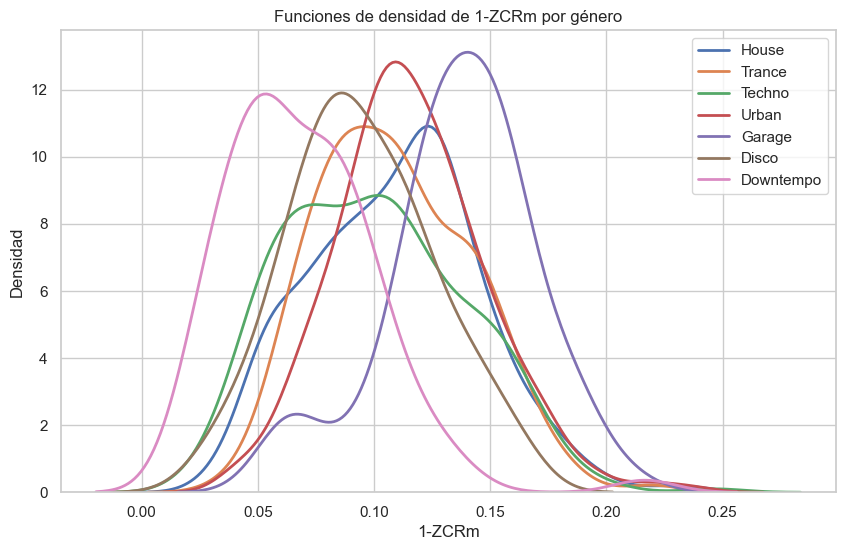

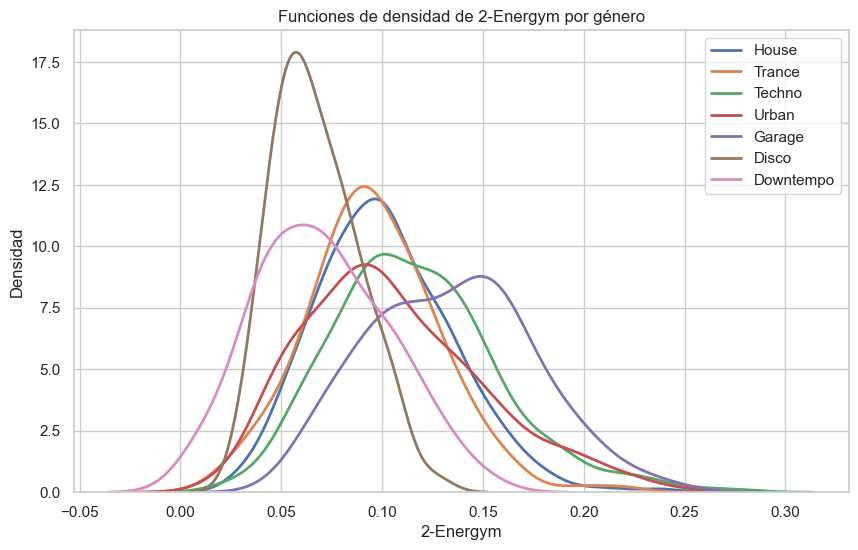

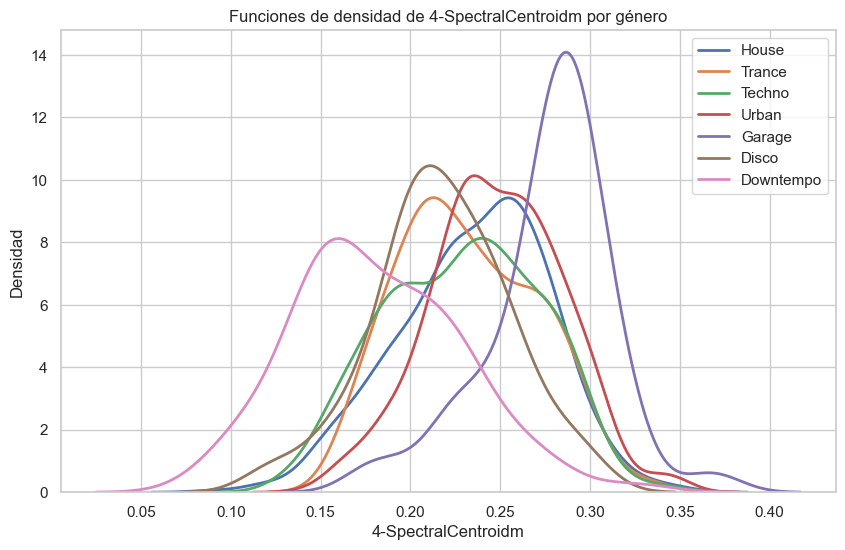

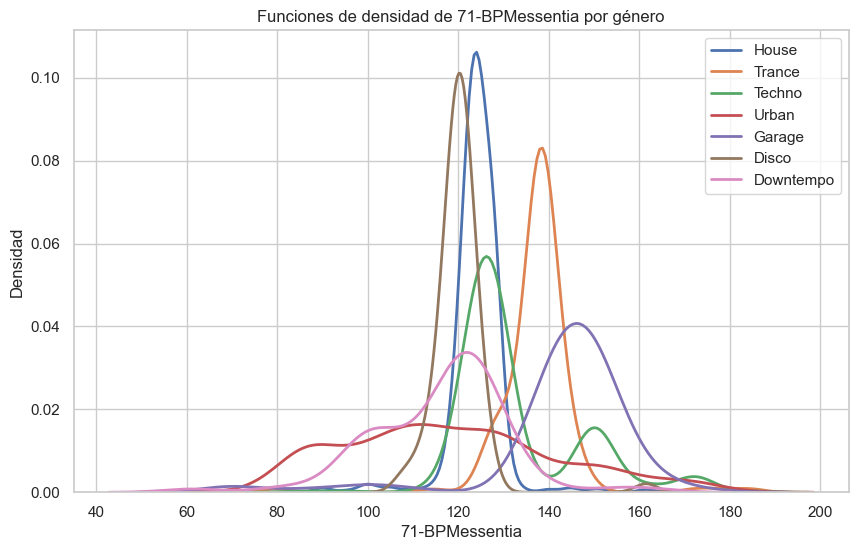

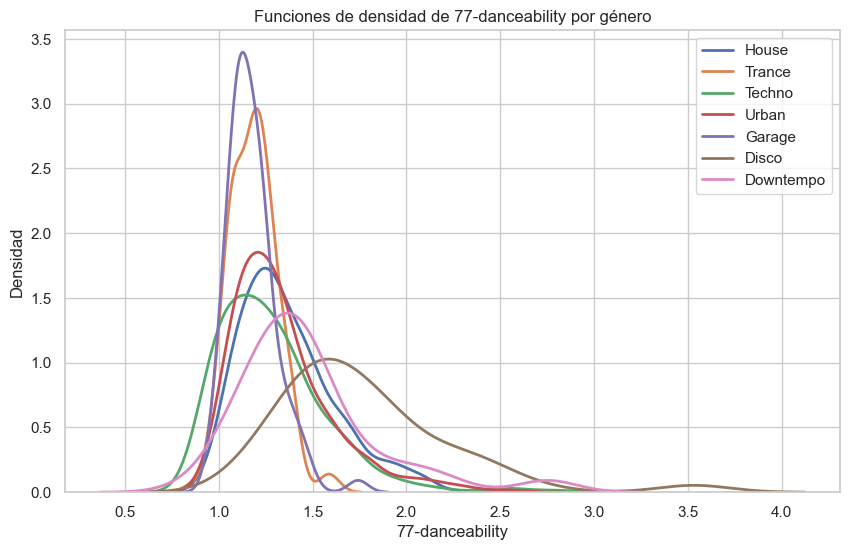

In [52]:
selected_variables = ['1-ZCRm', '2-Energym', '4-SpectralCentroidm', '71-BPMessentia', '77-danceability']

for var in selected_variables:
    plt.figure(figsize=(10, 6))
    for clase in train_set['new_target'].unique():
        sns.kdeplot(
            data=train_set[train_set['new_target'] == clase],
            x=var,
            label=clase,
            linewidth=2
        )
    plt.title(f'Funciones de densidad de {var} por género')
    plt.xlabel(var)
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()


In [53]:
selected_columns

['1-ZCRm',
 '2-Energym',
 '4-SpectralCentroidm',
 '71-BPMessentia',
 '77-danceability']

Todas aportan información valiosa para distinguir el género, pero veo que en '2-Energym', '4-SpectralCentroidm', '77-danceability' hay algunas funciones que se superponen y no hay desplazamientos tan marcados como en '1-ZCRm' y '71-BPMessentia'

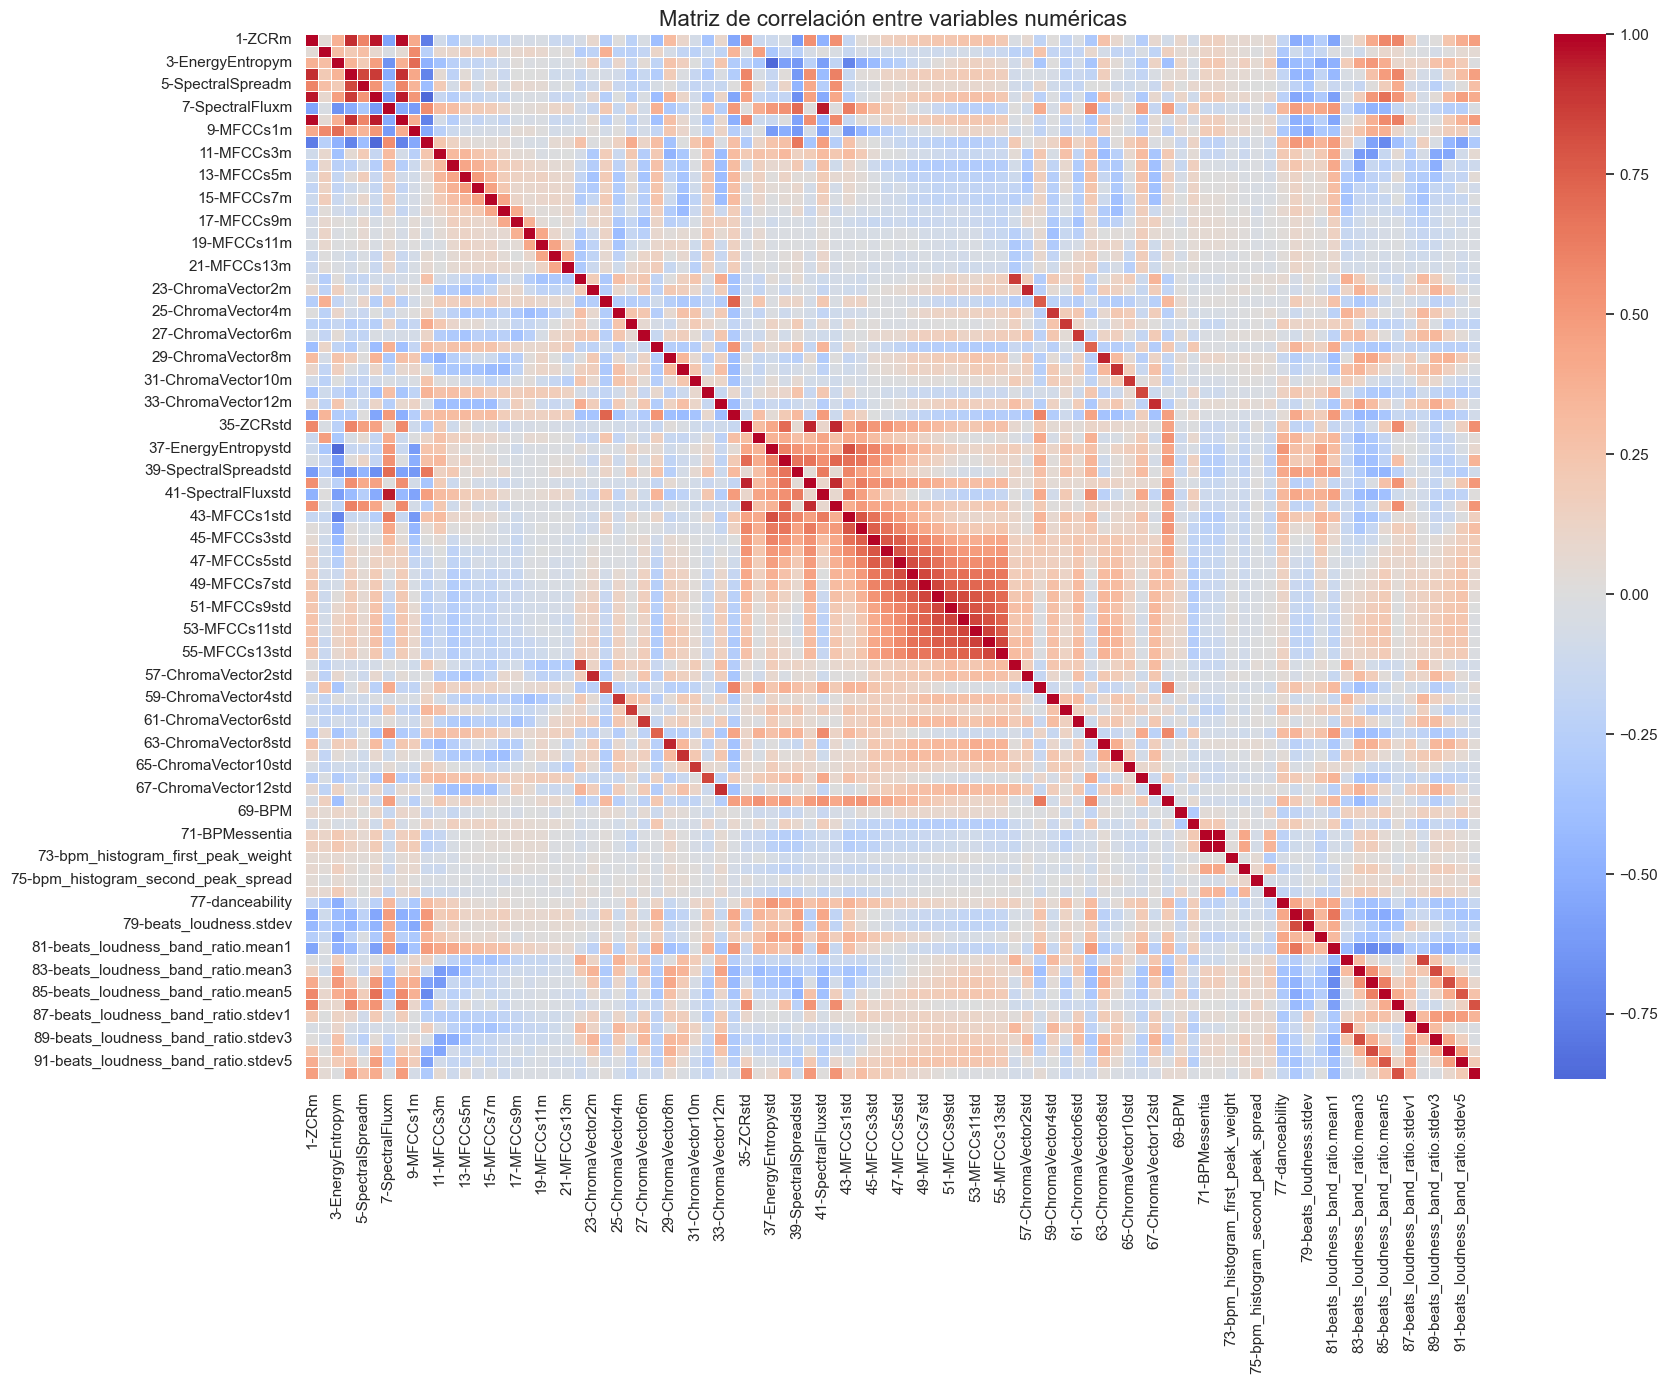

In [57]:

# Filtrar solo las columnas numéricas para calcular la matriz de correlación

numeric_df = train_set.drop(['class', 'new_target'], axis=1)
correlation_matrix = numeric_df.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Matriz de correlación entre variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()

Si bien son muchisimas variables como para entrar en detalle en un grafico así, igualmente podemos ver que hay variables con una correlación extrema, seguimos buscando.

Confirmamos lo que intuía, obsvervo correlaciones fuertes positivas entre columnas del mismo tipo:
- MFCCs medios (9–21) y sus correspondientes stds (43–55)
- ChromaVector medios y stds (22–34 vs. 56–68)
- beats_loudness_band_ratio.mean# con sus respectivas stdev#

Por otro lado:
- 77-danceability y 71-BPMessentia tienen correlaciones moderadas con varias otras métricas rítmicas y energéticas.
- 69-BPM, 72-bpm_histogram_first_peak_bpm y 71-BPMessentia están correlacionadas, como era esperable.

Para limpiar un poco el ruido, y teniendo en cuenta que cuento con múltiples variables que se refieren al mismo aspecto del sample de audio, voy a agrupar mis variables

In [70]:
features = train_set.drop(['class', 'new_target'], axis=1)

In [71]:
# Agrupar columnas por tipo de feature
groups = {
    'ZCR': [col for col in features if 'ZCR' in col],
    'Energy': [col for col in features if 'Energy' in col],
    'Spectral': [col for col in features if 'Spectral' in col],
    'MFCCs': [col for col in features if 'MFCCs' in col],
    'Chroma': [col for col in features if 'ChromaVector' in col or 'ChromaDeviation' in col],
    'BPM': [col for col in features if 'BPM' in col or 'onset_rate' in col or 'bpm' in col],
    'Beats Loudness': [col for col in features if 'beats_loudness' in col],
    'Danceability': [col for col in features if 'danceability' in col],
    'Otros': [col for col in features if col not in (
        ['class', 'id'] +
        [v for sublist in [
            [col for col in features if 'ZCR' in col],
            [col for col in features if 'Energy' in col],
            [col for col in features if 'Spectral' in col],
            [col for col in features if 'MFCCs' in col],
            [col for col in features if 'ChromaVector' in col or 'ChromaDeviation' in col],
            [col for col in features if 'BPM' in col or 'onset_rate' in col or 'bpm' in col],
            [col for col in features if 'beats_loudness' in col],
            [col for col in features if 'danceability' in col],
        ] for v in sublist]
    )]
}

In [72]:
groups


{'ZCR': ['1-ZCRm', '35-ZCRstd'],
 'Energy': ['2-Energym',
  '3-EnergyEntropym',
  '36-Energystd',
  '37-EnergyEntropystd'],
 'Spectral': ['4-SpectralCentroidm',
  '5-SpectralSpreadm',
  '6-SpectralEntropym',
  '7-SpectralFluxm',
  '8-SpectralRolloffm',
  '38-SpectralCentroidstd',
  '39-SpectralSpreadstd',
  '40-SpectralEntropystd',
  '41-SpectralFluxstd',
  '42-SpectralRolloffstd'],
 'MFCCs': ['9-MFCCs1m',
  '10-MFCCs2m',
  '11-MFCCs3m',
  '12-MFCCs4m',
  '13-MFCCs5m',
  '14-MFCCs6m',
  '15-MFCCs7m',
  '16-MFCCs8m',
  '17-MFCCs9m',
  '18-MFCCs10m',
  '19-MFCCs11m',
  '20-MFCCs12m',
  '21-MFCCs13m',
  '43-MFCCs1std',
  '44-MFCCs2std',
  '45-MFCCs3std',
  '46-MFCCs4std',
  '47-MFCCs5std',
  '48-MFCCs6std',
  '49-MFCCs7std',
  '50-MFCCs8std',
  '51-MFCCs9std',
  '52-MFCCs10std',
  '53-MFCCs11std',
  '54-MFCCs12std',
  '55-MFCCs13std'],
 'Chroma': ['22-ChromaVector1m',
  '23-ChromaVector2m',
  '24-ChromaVector3m',
  '25-ChromaVector4m',
  '26-ChromaVector5m',
  '27-ChromaVector6m',
  '28-C

Una vez tengo ya las variables divididas en grupo por características de sonido, paso a realizar un test estadístico para filtrar por las que mayor relevancia tienen y continuar el análisis.

In [74]:
# Ejecutar ANOVA para cada grupo y encontrar la variable más significativa
anova_results = {}

for group_name, columns in groups.items():
    p_values = {}
    for col in columns:
        try:
            groups_data = [train_set[train_set['new_target'] == cls][col] for cls in train_set['new_target'].unique()]
            f_stat, p_val = f_oneway(*groups_data)
            p_values[col] = p_val
        except:
            continue  # En caso de error (ej. columnas con valores constantes)
    
    # Ordenar por menor p-valor y guardar la más significativa
    if p_values:
        best_col = min(p_values, key=p_values.get)
        anova_results[group_name] = {
            'best_feature': best_col,
            'p_value': p_values[best_col]
        }

# Convertir a DataFrame para mostrar
anova_df = pd.DataFrame(anova_results).T.sort_values(by='p_value')
anova_df

best_feature p_value
MFCCs                     48-MFCCs6std     0.0
BPM                         70-BPMconf     0.0
Spectral         40-SpectralEntropystd     0.0
ZCR                          35-ZCRstd     0.0
Danceability           77-danceability     0.0
Energy             37-EnergyEntropystd     0.0
Beats Loudness  78-beats_loudness.mean     0.0
Chroma               28-ChromaVector7m     0.0

Aquí tengo una selección a partir de un método estadístico de las features que voy a analizar. Si bien el test me selecciono para el grupo de BPM '70-BPMconf', por conocimiento de negocio esa la voy a descartar y voy a quedarme con la que había elegido inicialmente que era '71-BPMessentia'

In [91]:
selected_features = [
    '48-MFCCs6std',
    '71-BPMessentia',
    '40-SpectralEntropystd',
    '35-ZCRstd',
    '77-danceability',
    '37-EnergyEntropystd',
    '78-beats_loudness.mean',
    '28-ChromaVector7m'
]

In [163]:
train_set.loc[train_set['new_target'] == 'Downtempo', '71-BPMessentia'].describe()

count     84.000000
mean     116.175462
std       14.726028
min       60.963341
25%      106.309689
50%      119.996239
75%      124.265150
max      162.367203
Name: 71-BPMessentia, dtype: float64

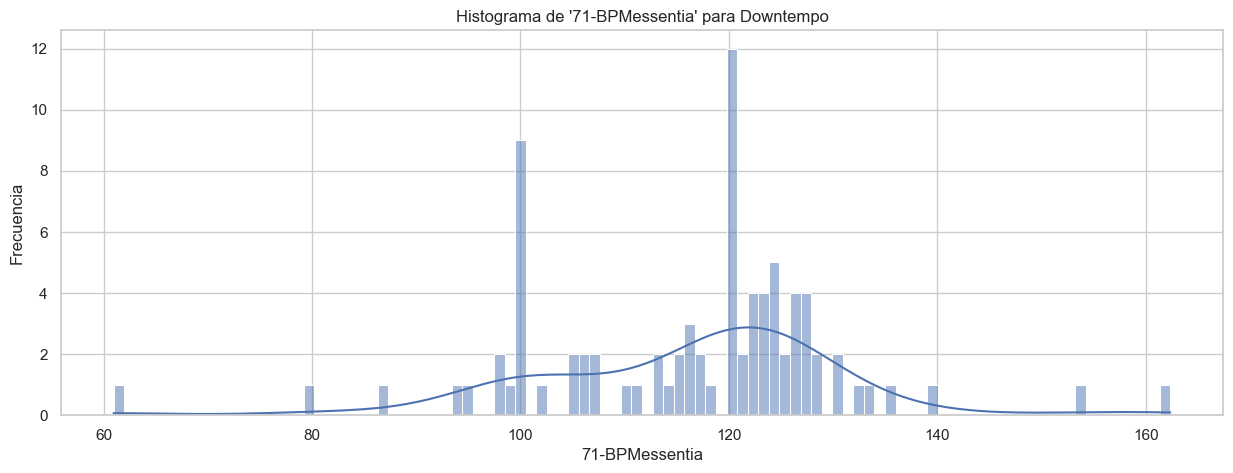

In [161]:
plt.figure(figsize=(15, 5))
sns.histplot(train_set.loc[train_set['new_target'] == 'Downtempo', '71-BPMessentia'], bins=100, kde=True)
plt.title("Histograma de '71-BPMessentia' para Downtempo")
plt.xlabel('71-BPMessentia')
plt.ylabel('Frecuencia')
plt.show()

Por conocimiento de negocio, y al ver los valores de '71-BPMessentia' para Downtempo me encuentro con valores raros. En la producción de canciones de Downtempo muchas veces se utiliza un bpm de produccion duplicado, pero la cancion igualmente se encuentra a una velocidad baja. Es decir, técnicamente mi canción puede estar a una velocidad de 120bpm pero su composición y velocidad real es a 60bpm. Es por esto que voy a pasar a dividir a la mitad los valores que se encuentren por encima de 110. 

In [164]:
mask = (train_set['new_target'] == 'Downtempo') & (train_set['71-BPMessentia'] > 110)
train_set.loc[mask, '71-BPMessentia'] = train_set.loc[mask, '71-BPMessentia'] / 2

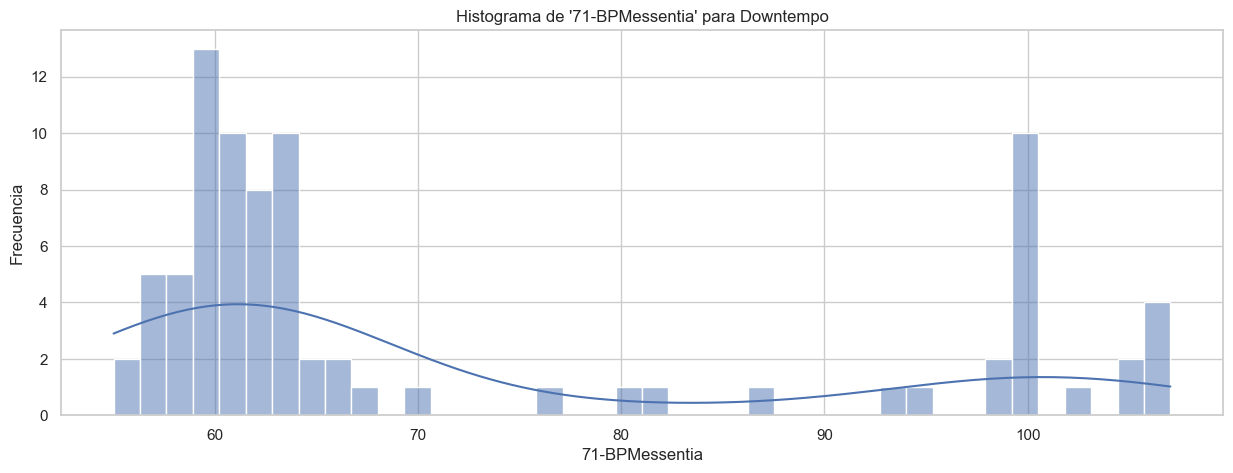

In [166]:
plt.figure(figsize=(15, 5))
sns.histplot(train_set.loc[train_set['new_target'] == 'Downtempo', '71-BPMessentia'], bins=40, kde=True)
plt.title("Histograma de '71-BPMessentia' para Downtempo")
plt.xlabel('71-BPMessentia')
plt.ylabel('Frecuencia')
plt.show()

Esta distribución tiene muchísimo más sentido y de esta manera, estandarizamos los valores de BPM para todos los generos

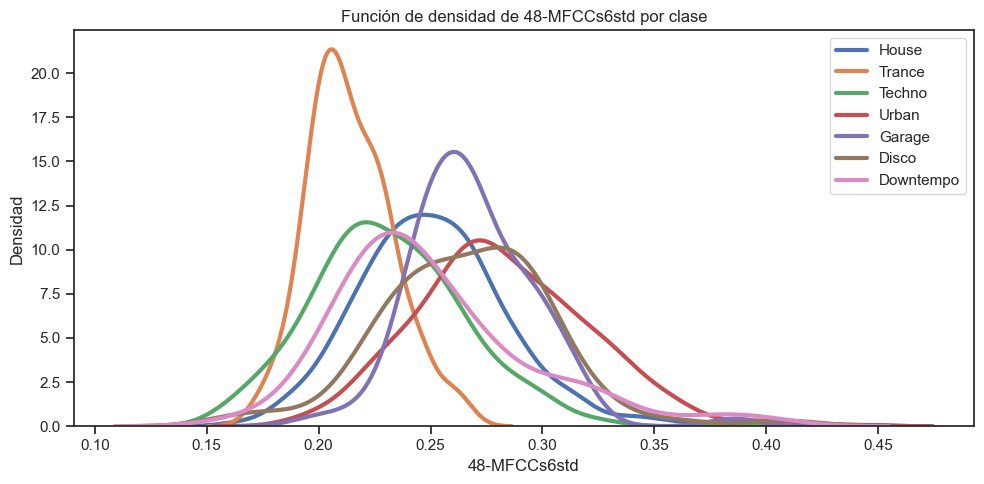

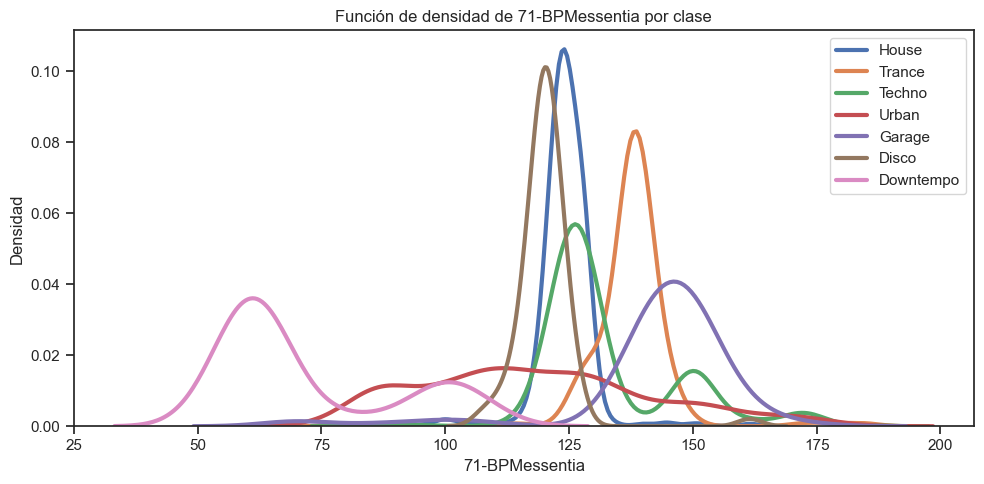

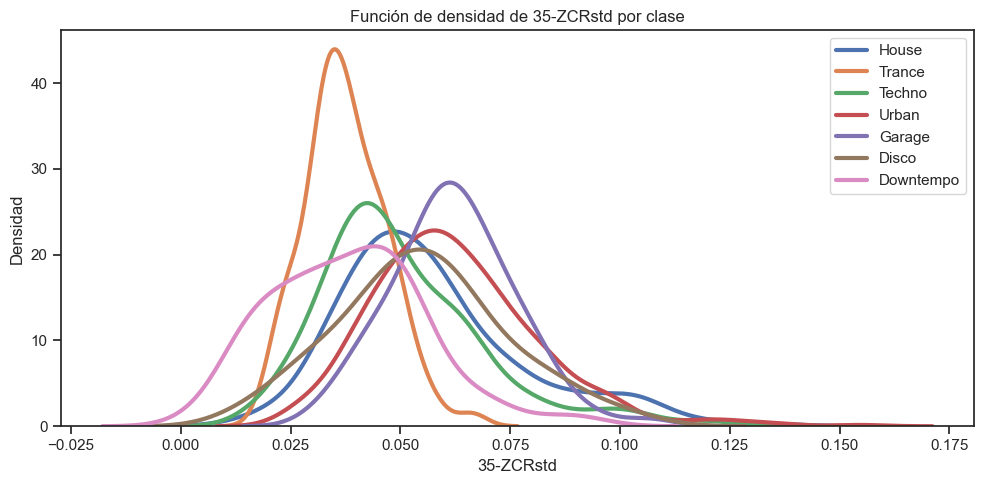

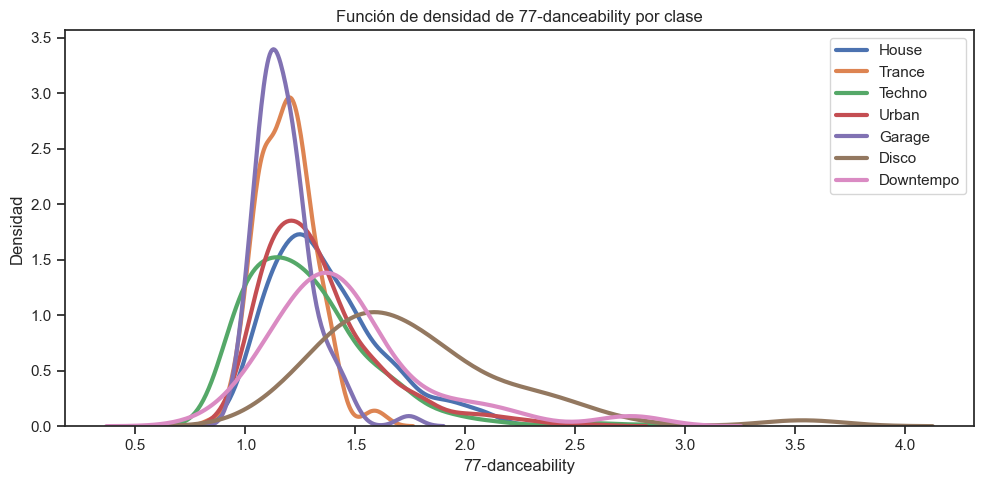

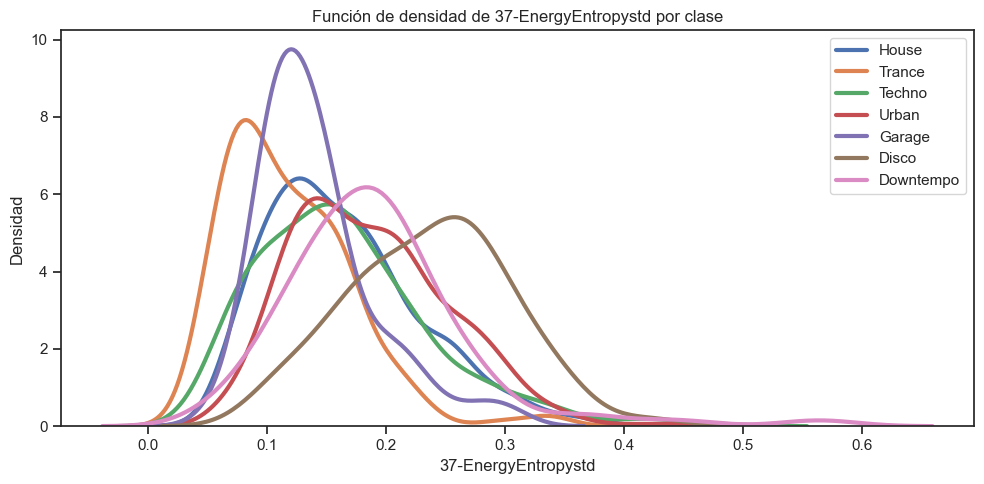

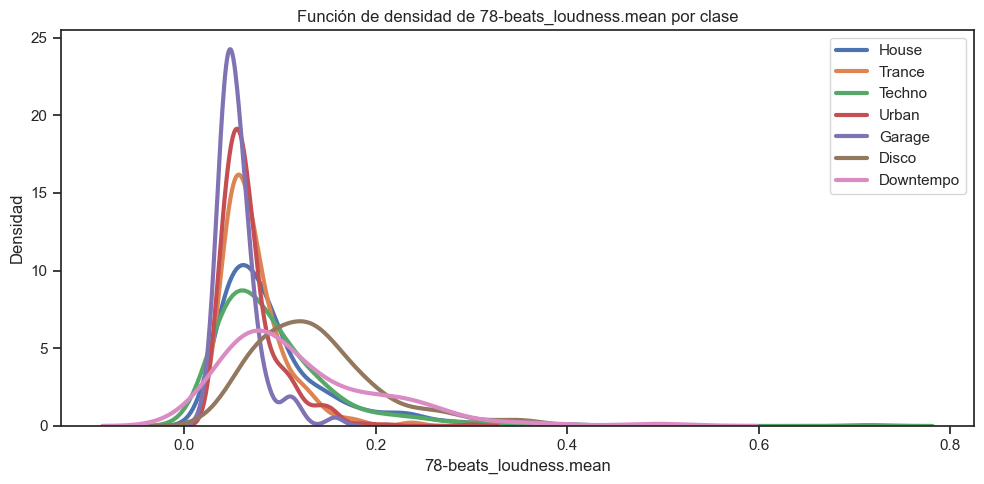

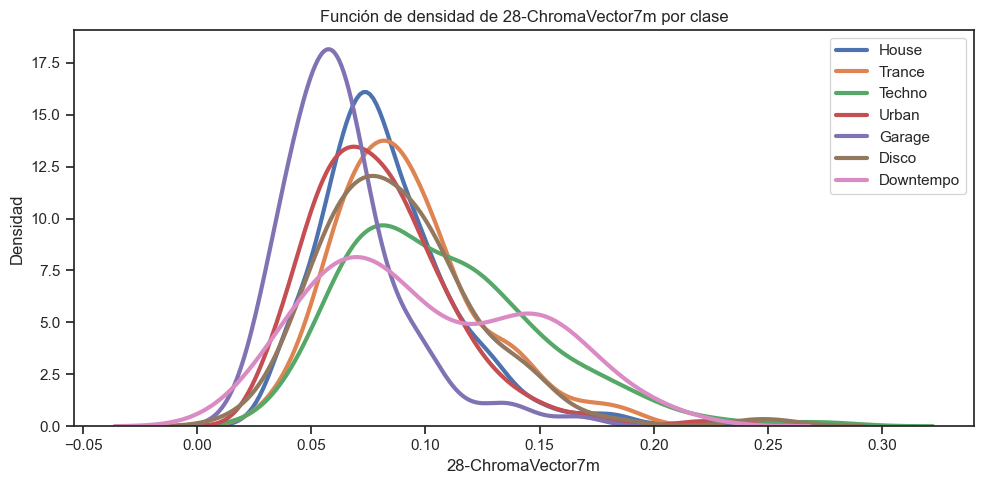

In [167]:
sns.set(style="ticks")
for feature in selected_features:
    plt.figure(figsize=(10, 5))
    for clase in train_set['new_target'].unique():
        sns.kdeplot(
            data=train_set[train_set['new_target'] == clase],
            x=feature,
            label=clase,
            linewidth=3
        )
    plt.title(f"Función de densidad de {feature} por clase")
    plt.xlabel(feature)
    plt.ylabel("Densidad")
    plt.legend()
    plt.tight_layout()
    plt.show()

- La varianza de los coeficientes MFCC6 sugiere diferencias significativas en la complejidad armónica entre géneros. El Trance se distingue claramente por su menor dispersión y pico más alto, Urban y Garage muestran valores mayores.

- 71-BPMessentia como ya sabíamos de ante mano, discrimina perfecto por género, ya que el tempo es una de las características determinantes al momento de definir ciertos géneros. 

- Variables como 71-BPMessentia, 40-SpectralEntropystd, 35-ZCRstd, 37-EnergyEntropystd, y 48-MFCCs6std muestran distribuciones bien diferenciadas por clase y por tanto alta capacidad discriminativa.

- 77-danceability y 78-beats_loudness.mean también aportan valor, aunque con algo más de solapamiento.

- 28-ChromaVector7m es relevante, pero quizás algo menos diferenciadora que el resto.

- Me doy cuenta que las graficas de 35-ZCRstd y 37-EnergyEntropystd tienen una distribución casi idéntica. Se tendrá en cuenta al momento de analizar la correlación.

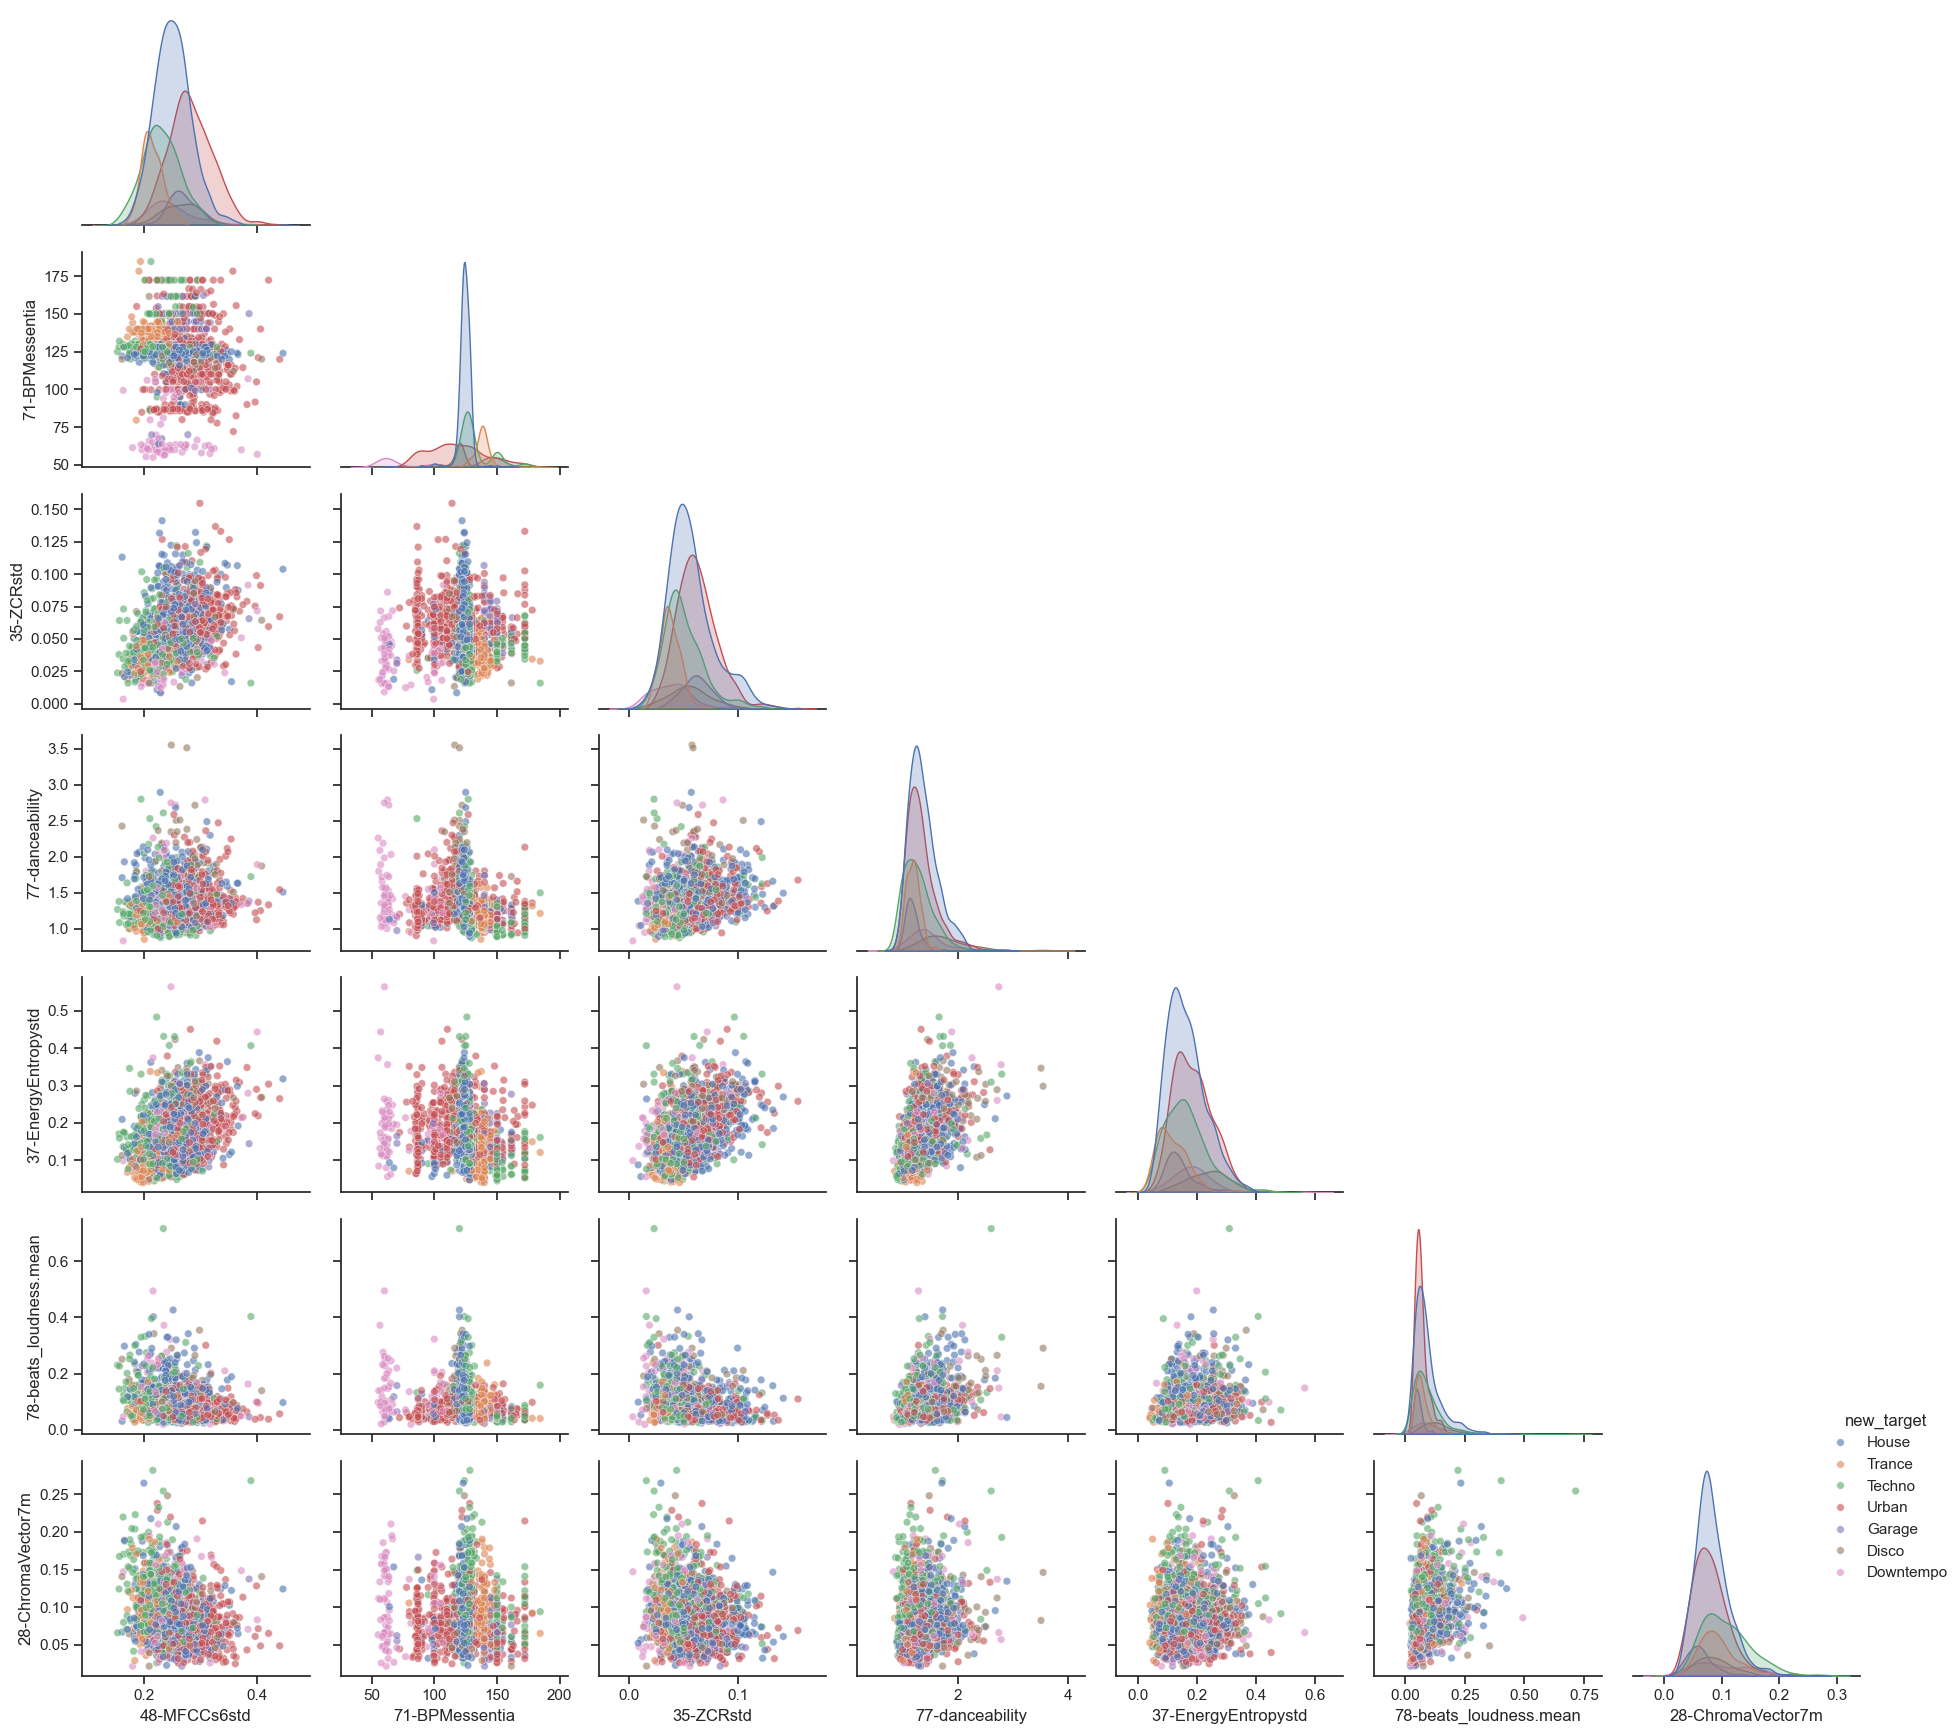

In [168]:
new_target = 'new_target'
# Creamos el pairplot con seaborn
sns.set(style="ticks")
pairplot_fig = sns.pairplot(
    train_set[selected_features + [new_target]],
    hue=new_target,
    plot_kws={"alpha": 0.6, "s": 30},
    corner=True
)
plt.tight_layout()
# Colocar la leyenda abajo a la derecha pero un poco más arriba
pairplot_fig._legend.set_bbox_to_anchor((1, 0.08))
pairplot_fig._legend.set_loc("lower center")
plt.show()

- Podemos observar en la columna de '71-BPMessentia' como se forman filas verticales para géneros como House, Urban, Techno, Trance y Downtempo son los que mejor discriminados se ven. Luego no se observa una separación fuerte entre géneros en las otras variables, salvo entre 35-ZCRstd y 40-SpectralEntropystd que parecería haber algún tipo de forma/figura a agrupar tambien. 
- 35-ZCRstd y 40-SpectralEntropystd tienen una relación positiva fuerte. Esto sugiere que estas tres variables están capturando una dimensión común del espectro energético/frecuencial.
- 77-danceability y 71-BPMessentia no tienen correlación aparente con otras variables, esto es bueno ya que aportan nueva información no redundante. 
- No se observa una separación visual fuerte entre géneros, pero algunas combinaciones como 'BPMessentia' vs 'MFCCs6std' muestran agrupamientos parciales. Me doy cuenta que géneros como House, Urban, Techno y Trance (que también son los que mayor frecuencia tienen) son los que mejor discriminados se ven por '71-BPMessentia' y ''48-MFCCs6std'

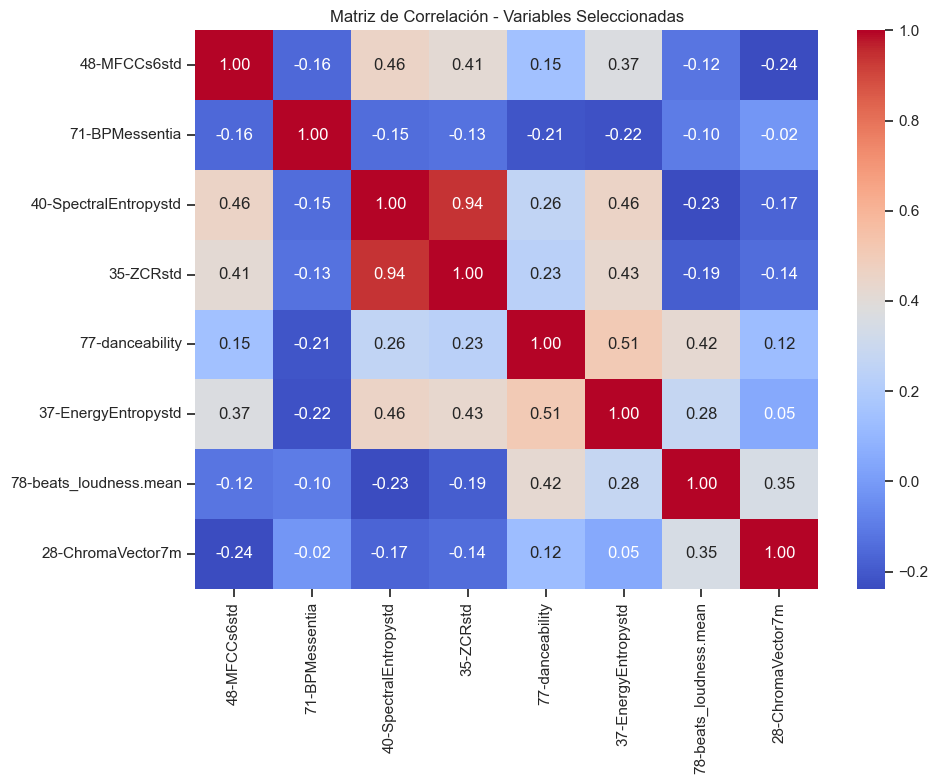

In [133]:

# Matriz de correlación de las features seleccionadas
correlation_matrix = train_set[selected_features].corr()

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación - Variables Seleccionadas")
plt.tight_layout()
plt.show()

'40-SpectralEntropystd': La entropía espectral es una medida de la complejidad o desorden en un espectro de frecuencias,
'1- ZCRstd': es la métrica utilizada en el procesamiento de señales que indica la velocidad a la que una señal cambia de signo, es decir, de positiva a negativa o viceversa.
Por su alta colinealidad y lo que ambas significan, me decido por mantener '1- ZCRmstd'

In [139]:
selected_features.remove('40-SpectralEntropystd')

In [169]:
train_set[selected_features].describe().T

count        mean        std        min         25%  \
48-MFCCs6std            1840.0    0.253828   0.040900   0.153214    0.224554   
71-BPMessentia          1840.0  123.601815  20.016979  55.019028  120.007723   
35-ZCRstd               1840.0    0.054724   0.020417   0.003630    0.040609   
77-danceability         1840.0    1.343336   0.298108   0.830938    1.140167   
37-EnergyEntropystd     1840.0    0.168717   0.069908   0.040537    0.117027   
78-beats_loudness.mean  1840.0    0.086712   0.057373   0.018995    0.051132   
28-ChromaVector7m       1840.0    0.087810   0.036007   0.021836    0.063294   

                               50%         75%         max  
48-MFCCs6std              0.251059    0.277568    0.445822  
71-BPMessentia          124.987633  129.966553  184.570297  
35-ZCRstd                 0.051675    0.065675    0.154560  
77-danceability           1.274727    1.470299    3.552394  
37-EnergyEntropystd       0.158269    0.210560    0.563781  
78-beats_loudness.mean    0.069063    0.102190    0.715360  
28-ChromaVector7m         0.080770    0.105475    0.281762

Observo que los datos se encuentran estandarizados al parecer, no veo ninguna distribución extraña, teniendo en cuenta que son resultados de un análisis de una onda de audio. Por conocimiento de negocio está bien que haya una mayor amplitud y discreción de valores en '71-BPMessentia' ya que se refiere al tempo de la muestra de audio y esta puede ir de 0 a 240 practicamente. 

#### Respuestas

1. ¿Es el House el género más bailable?

/var/folders/tb/bzmqvp956c176vyy0ydx7kl00000gn/T/ipykernel_61010/3330973871.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Género')


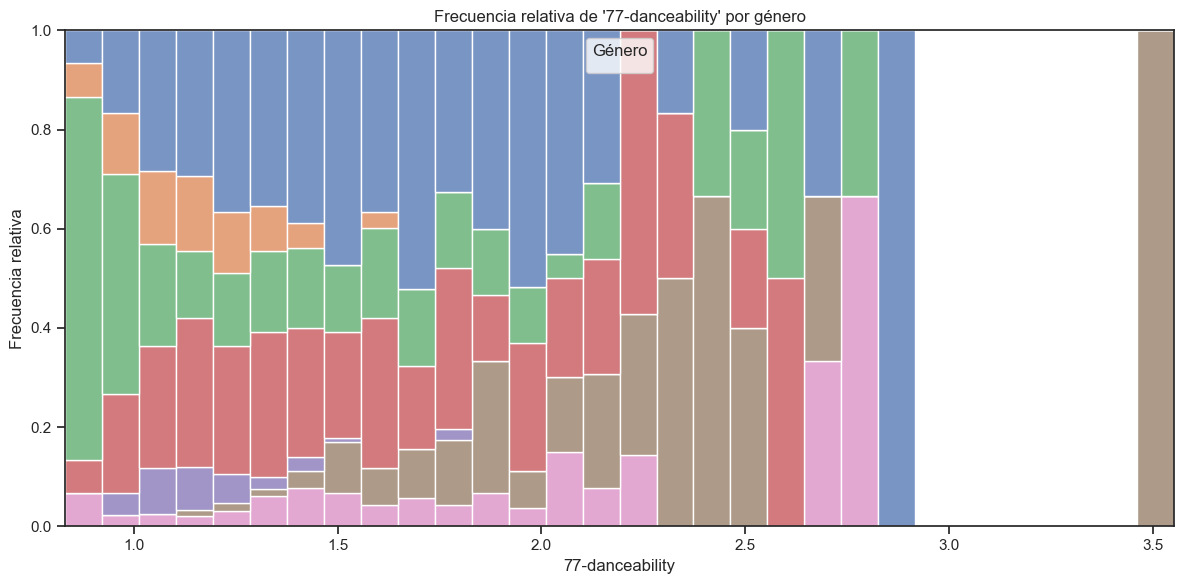

In [181]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data=train_set,
    x='77-danceability',
    hue='new_target',
    multiple='fill',  # frecuencia relativa por clase
    bins=30,
    stat='probability'
)
plt.title("Frecuencia relativa de '77-danceability' por género")
plt.xlabel('77-danceability')
plt.ylabel('Frecuencia relativa')
plt.legend(title='Género')
plt.tight_layout()
plt.show()

/var/folders/tb/bzmqvp956c176vyy0ydx7kl00000gn/T/ipykernel_61010/2962647948.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


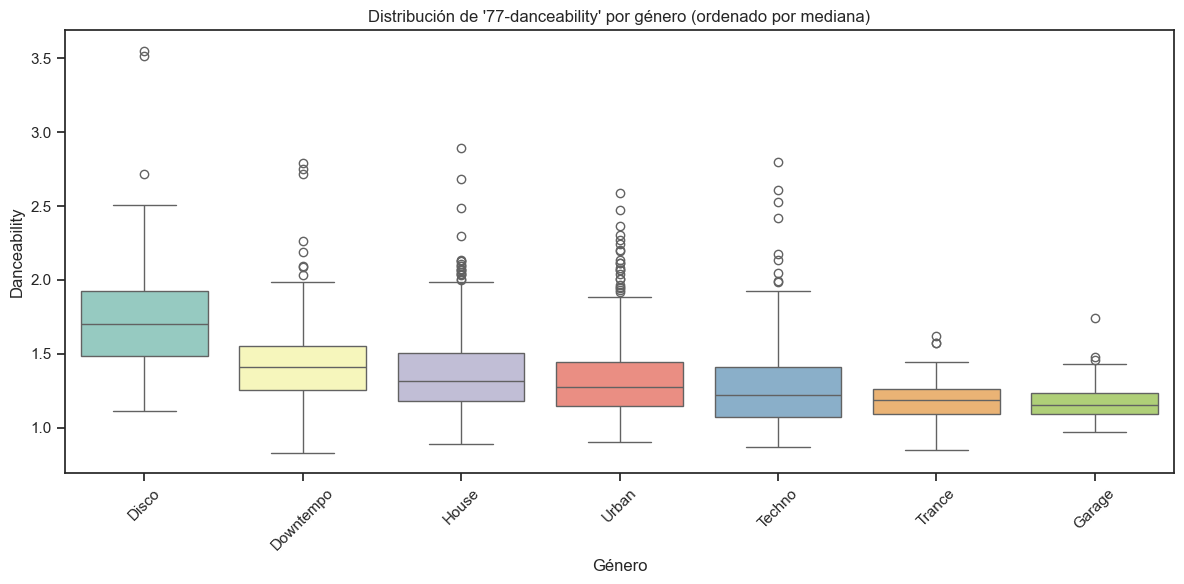

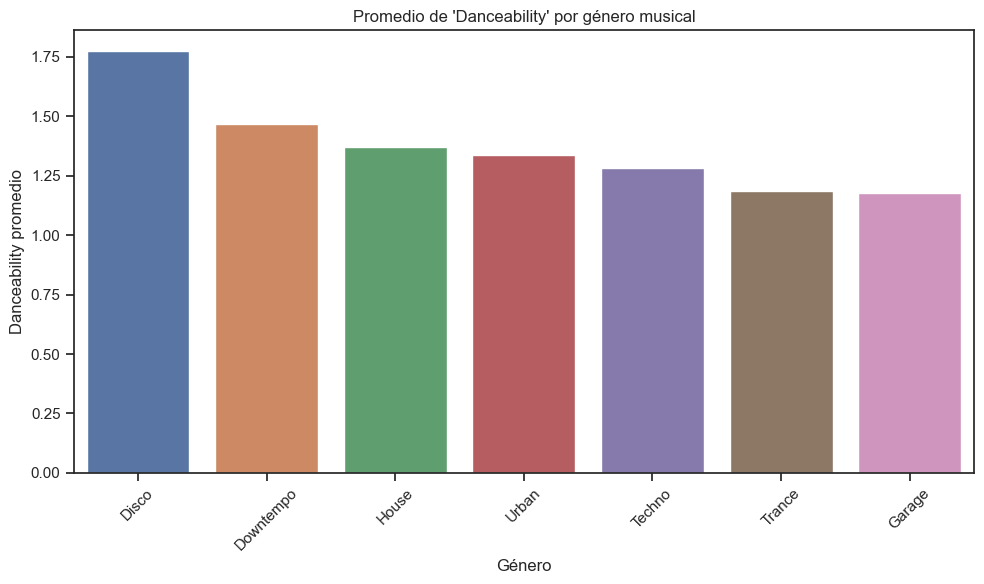

In [186]:
# Calcular la media de danceability por género
mean_danceability = train_set.groupby('new_target')['77-danceability'].mean().sort_values(ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(
    x=mean_danceability.index,
    y=mean_danceability.values,
    hue=mean_danceability.index
)
plt.title("Promedio de 'Danceability' por género musical")
plt.ylabel("Danceability promedio")
plt.xlabel("Género")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Feat. Red. Preliminar

In [70]:
X = train_set.drop(columns=['class', '69-BPM', '70-BPMconf'])
y = train_set['class']

In [71]:
rf = RandomForestClassifier(random_state=42)
selector_modelo = SelectFromModel(estimator = rf, threshold="median")

selector_modelo.fit(X, y)

features_modelo = list(selector_modelo.get_feature_names_out())

In [72]:
# Obtener el modelo Random Forest entrenado dentro del selector
modelo_entrenado = selector_modelo.estimator_

# Crear el DataFrame con importancias
importancias = modelo_entrenado.feature_importances_
columnas = X.columns

df_importancia = pd.DataFrame({
    "feature": columnas,
    "importance": importancias
}).sort_values(by="importance", ascending=False).reset_index(drop=True)

# Ver solo las seleccionadas si querés:
df_seleccionadas = df_importancia[df_importancia["importance"] >= selector_modelo.threshold_]


In [73]:
df_seleccionadas

feature  importance
0                        71-BPMessentia    0.063539
1       72-bpm_histogram_first_peak_bpm    0.047675
2                          44-MFCCs2std    0.017693
3                             2-Energym    0.016334
4                  39-SpectralSpreadstd    0.016293
5                      3-EnergyEntropym    0.015411
6                             9-MFCCs1m    0.015356
7                38-SpectralCentroidstd    0.015345
8                          43-MFCCs1std    0.014645
9                         52-MFCCs10std    0.014349
10                        54-MFCCs12std    0.014340
11                         48-MFCCs6std    0.014285
12                      7-SpectralFluxm    0.014271
13     74-bpm_histogram_second_peak_bpm    0.014242
14                      77-danceability    0.014104
15                   41-SpectralFluxstd    0.013799
16                         50-MFCCs8std    0.013453
17                        55-MFCCs13std    0.013296
18                         45-MFCCs3std    0.012755
19                         51-MFCCs9std    0.012463
20                           10-MFCCs2m    0.012390
21              79-beats_loudness.stdev    0.012325
22                  4-SpectralCentroidm    0.012181
23                         47-MFCCs5std    0.012019
24               78-beats_loudness.mean    0.011582
25   86-beats_loudness_band_ratio.mean6    0.011378
26  88-beats_loudness_band_ratio.stdev2    0.011239
27                         46-MFCCs4std    0.011120
28   81-beats_loudness_band_ratio.mean1    0.010997
29                   6-SpectralEntropym    0.010995
30                        80-onset_rate    0.010958
31                        53-MFCCs11std    0.010912
32                         49-MFCCs7std    0.010895
33   85-beats_loudness_band_ratio.mean5    0.010804
34                    24-ChromaVector3m    0.010715
35                               1-ZCRm    0.010714
36                  37-EnergyEntropystd    0.010653
37   82-beats_loudness_band_ratio.mean2    0.010494
38                40-SpectralEntropystd    0.010350
39                  34-ChromaDeviationm    0.010129
40                            35-ZCRstd    0.010002
41                    5-SpectralSpreadm    0.009850
42  87-beats_loudness_band_ratio.stdev1    0.009704
43                  58-ChromaVector3std    0.009538
44                         36-Energystd    0.009481

In [ ]:
variables_seleccionadas = df_seleccionadas['feature'].tolist()



In [109]:
len(variables_seleccionadas)

45

Luego de hacer un feature selection preliminar obtengo 46 variables. Sigo encontrandome con variables con nombres muy similares, lo que me llevan a pensar que pueden estar aportando información redundante al modelo. Voy a analizar ahora si su colinealidad

In [75]:

# Convertir a long-form y eliminar duplicados
corr_matrix = train_set[variables_seleccionadas].corr(numeric_only=True)
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # solo triángulo superior
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Var1', 'Var2', 'Correlation']

# Filtrar correlaciones fuertes (positivas o negativas)
high_corr = corr_pairs[abs(corr_pairs['Correlation']) > 0.8].sort_values(by='Correlation', ascending=False)

high_corr

Var1                                Var2  \
0                         71-BPMessentia     72-bpm_histogram_first_peak_bpm   
875                   6-SpectralEntropym                              1-ZCRm   
464                      7-SpectralFluxm                  41-SpectralFluxstd   
970                40-SpectralEntropystd                           35-ZCRstd   
749                  4-SpectralCentroidm                              1-ZCRm   
743                  4-SpectralCentroidm                  6-SpectralEntropym   
415                        54-MFCCs12std                       53-MFCCs11std   
369                        52-MFCCs10std                        51-MFCCs9std   
381                        52-MFCCs10std                       53-MFCCs11std   
401                        54-MFCCs12std                       55-MFCCs13std   
829  88-beats_loudness_band_ratio.stdev2  82-beats_loudness_band_ratio.mean2   
586                         50-MFCCs8std                        51-MFCCs9std   
599                         50-MFCCs8std                        49-MFCCs7std   
755                  4-SpectralCentroidm                   5-SpectralSpreadm   
449                         48-MFCCs6std                        49-MFCCs7std   
716              79-beats_loudness.stdev              78-beats_loudness.mean   
440                         48-MFCCs6std                        47-MFCCs5std   
366                        52-MFCCs10std                        50-MFCCs8std   
351                         43-MFCCs1std                 37-EnergyEntropystd   
360                        52-MFCCs10std                       54-MFCCs12std   
240                     3-EnergyEntropym                 37-EnergyEntropystd   
698                           10-MFCCs2m                  6-SpectralEntropym   

     Correlation  
0       0.992390  
875     0.963170  
464     0.955521  
970     0.939514  
749     0.913865  
743     0.872814  
415     0.857654  
369     0.850149  
381     0.846914  
401     0.846902  
829     0.844935  
586     0.841936  
599     0.841768  
755     0.838348  
449     0.836640  
716     0.822509  
440     0.820171  
366     0.819136  
351     0.806740  
360     0.804523  
240    -0.860267  
698    -0.865418

Veo que hay grupos de variables que estan altamente correlados, entiendo por su nombre y por su alto grado de correlación que estan aportando información similar al modelo, por lo que voy a proceder a elegir la de mayor importancia de estos grupos y dejar las demas de lado tambien teniendo en cuenta, a partir del conocimiento de negocio, cuales son las que me ayudaran en mayor medida a mi modelo.

- 71-BPMessentia, 72-bpm_histogram_first_peak_bpm : Me quedo primero con '71-BPMessentia' porque entiendo tambien por conocimiento de negocio que están aportando la misma información.
- 6-SpectralEntropym, 1-ZCRm: Veo que '6-SpectralEntropym' tiene mayor importancia que '1-ZCRm' y correlan muchisimo, además de que la segunda correla tambien con otras variables, me quedo con la primera.
- 7-SpectralFluxm, 41-SpectralFluxstd: una es su media y la otra su desvío estándar, me quedo con la primera.
- 40-SpectralEntropystd, 35-ZCRstd: mismo caso que en la segunda fila, pero esta vez con sus desvíos estándar, por uniformidad e orden de importancia, me quedo con la primera.
- 4-SpectralCentroidm, 1-ZCRm y 6-SpectralEntropym: me quedo con la primera, ya que por orden de importancia, '1-ZCRm' esta en 35 y '4-SpectralCentroidm' en importancia 22. Mantengo '6-SpectralEntropym' ya que representan cualidades diferentes y específicas de mi sample de audio que creo que ayudarán mejor a mi modelo, según la información de las variables que tenemos del negocio.
- En las próximas 4 filas tenemos MFCCs desvíos estándar vs otros MFCCs desvíos estándar, descarto MFCCs9std, 11 y 13
- 88-beats_loudness_band_ratio.stdev2, 82-beats_loudness_band_ratio.mean2: Loudness beat media vs estándar, mantenemos la primera.	
- 50-MFCCs8std vs 51-MFCCs9std y 51-MFCCs7std: me encuentro pensando que las variables MFCC me aportan información valiosa, descarto las MFCC9 y 7
- 4-SpectralCentroidm, 5-SpectralSpreadm: me quedo con la primera, me aportan información redundante y correlan muchisimo. 
- 48-MFCCs6std, 49-MFCCs7std: la segunda ya la tenemos descartada.
- 79-beats_loudness.stdev, 78-beats_loudness.mean: desvío estándar vs media, descartamos la media
- 48-MFCCs6std, 47-MFCCs5std: descarto la de menor importancia
- 52-MFCCs10std, 50-MFCCs8std: descarto la de menor importancia
- 43-MFCCs1std, 37-EnergyEntropystd: el modelo considera mucho mas importante la primera variable que la segunda, descarto la segunda.	
- 52-MFCCs10std, 54-MFCCs12std: descarto la segunda.
- 10-MFCCs2m, 6-SpectralEntropym: las mantengo.

In [104]:
variables_descartadas = ['72-bpm_histogram_first_peak_bpm',
                         '1-ZCRm',
                         '41-SpectralFluxstd',
                         '35-ZCRstd',
                         '53-MFCCs11std',
                         '51-MFCCs9std',
                         '55-MFCCs13std',
                         '82-beats_loudness_band_ratio.mean2',
                         '49-MFCCs7std',
                         '5-SpectralSpreadm',
                         '78-beats_loudness.mean',
                         '47-MFCCs5std',
                         '50-MFCCs8std',
                         '37-EnergyEntropystd',
                         '54-MFCCs12std',
                         '87-beats_loudness_band_ratio.stdev1',
                         '58-ChromaVector3std',
                         '36-Energystd'	
                         ]	


In [105]:
feat_selec_imp_col = [feat for feat in variables_seleccionadas if feat not in variables_descartadas]
feat_selec_imp_col

['71-BPMessentia',
 '44-MFCCs2std',
 '2-Energym',
 '39-SpectralSpreadstd',
 '3-EnergyEntropym',
 '9-MFCCs1m',
 '38-SpectralCentroidstd',
 '43-MFCCs1std',
 '52-MFCCs10std',
 '48-MFCCs6std',
 '7-SpectralFluxm',
 '74-bpm_histogram_second_peak_bpm',
 '77-danceability',
 '45-MFCCs3std',
 '10-MFCCs2m',
 '79-beats_loudness.stdev',
 '4-SpectralCentroidm',
 '86-beats_loudness_band_ratio.mean6',
 '88-beats_loudness_band_ratio.stdev2',
 '46-MFCCs4std',
 '81-beats_loudness_band_ratio.mean1',
 '6-SpectralEntropym',
 '80-onset_rate',
 '85-beats_loudness_band_ratio.mean5',
 '24-ChromaVector3m',
 '40-SpectralEntropystd',
 '34-ChromaDeviationm']

In [110]:
train_set[feat_selec_imp_col].describe().T

count        mean        std        min  \
71-BPMessentia                       1840.0  125.615340  16.541219  60.963341   
44-MFCCs2std                         1840.0    0.577254   0.152649   0.240739   
2-Energym                            1840.0    0.103110   0.040310   0.004948   
39-SpectralSpreadstd                 1840.0    0.027507   0.008990   0.006781   
3-EnergyEntropym                     1840.0    3.111620   0.069601   2.809542   
9-MFCCs1m                            1840.0  -23.167597   1.180509 -30.378970   
38-SpectralCentroidstd               1840.0    0.059196   0.019405   0.016758   
43-MFCCs1std                         1840.0    1.161311   0.402062   0.340147   
52-MFCCs10std                        1840.0    0.214026   0.033262   0.123583   
48-MFCCs6std                         1840.0    0.253828   0.040900   0.153214   
7-SpectralFluxm                      1840.0    0.010626   0.005297   0.002692   
74-bpm_histogram_second_peak_bpm     1840.0  117.028804  37.603708   0.000000   
77-danceability                      1840.0    1.343336   0.298108   0.830938   
45-MFCCs3std                         1840.0    0.409039   0.089748   0.189974   
10-MFCCs2m                           1840.0    1.677193   0.564043  -0.019213   
79-beats_loudness.stdev              1840.0    0.058501   0.042981   0.006684   
4-SpectralCentroidm                  1840.0    0.235859   0.043519   0.082676   
86-beats_loudness_band_ratio.mean6   1840.0    0.095375   0.079644   0.000021   
88-beats_loudness_band_ratio.stdev2  1840.0    0.129142   0.064690   0.007370   
46-MFCCs4std                         1840.0    0.323399   0.061151   0.171393   
81-beats_loudness_band_ratio.mean1   1840.0    0.587102   0.169673   0.069540   
6-SpectralEntropym                   1840.0    0.910617   0.341926   0.034151   
80-onset_rate                        1840.0    4.748552   1.085302   0.499949   
85-beats_loudness_band_ratio.mean5   1840.0    0.060093   0.037420   0.000053   
24-ChromaVector3m                    1840.0    0.095034   0.042921   0.009860   
40-SpectralEntropystd                1840.0    0.463405   0.144645   0.026146   
34-ChromaDeviationm                  1840.0    0.045711   0.011075   0.018183   

                                            25%         50%         75%  \
71-BPMessentia                       120.040546  125.007256  130.002884   
44-MFCCs2std                           0.468792    0.569104    0.667459   
2-Energym                              0.074501    0.099288    0.127393   
39-SpectralSpreadstd                   0.020676    0.027166    0.033554   
3-EnergyEntropym                       3.066686    3.117736    3.163688   
9-MFCCs1m                            -23.949117  -23.097458  -22.282394   
38-SpectralCentroidstd                 0.044141    0.057290    0.071379   
43-MFCCs1std                           0.880408    1.118555    1.390259   
52-MFCCs10std                          0.190410    0.212000    0.235757   
48-MFCCs6std                           0.224554    0.251059    0.277568   
7-SpectralFluxm                        0.006714    0.009554    0.013130   
74-bpm_histogram_second_peak_bpm     112.000000  120.000000  133.000000   
77-danceability                        1.140167    1.274727    1.470299   
45-MFCCs3std                           0.346434    0.401473    0.466792   
10-MFCCs2m                             1.272778    1.629981    2.028859   
79-beats_loudness.stdev                0.031140    0.046562    0.071379   
4-SpectralCentroidm                    0.206872    0.237509    0.268193   
86-beats_loudness_band_ratio.mean6     0.040894    0.077113    0.123676   
88-beats_loudness_band_ratio.stdev2    0.082810    0.119993    0.166114   
46-MFCCs4std                           0.278436    0.318346    0.360880   
81-beats_loudness_band_ratio.mean1     0.470263    0.586755    0.702913   
6-SpectralEntropym                     0.660862    0.915671    1.164696   
80-onset_rate                          4.049

In [106]:
len(feat_selec_imp_col)

27

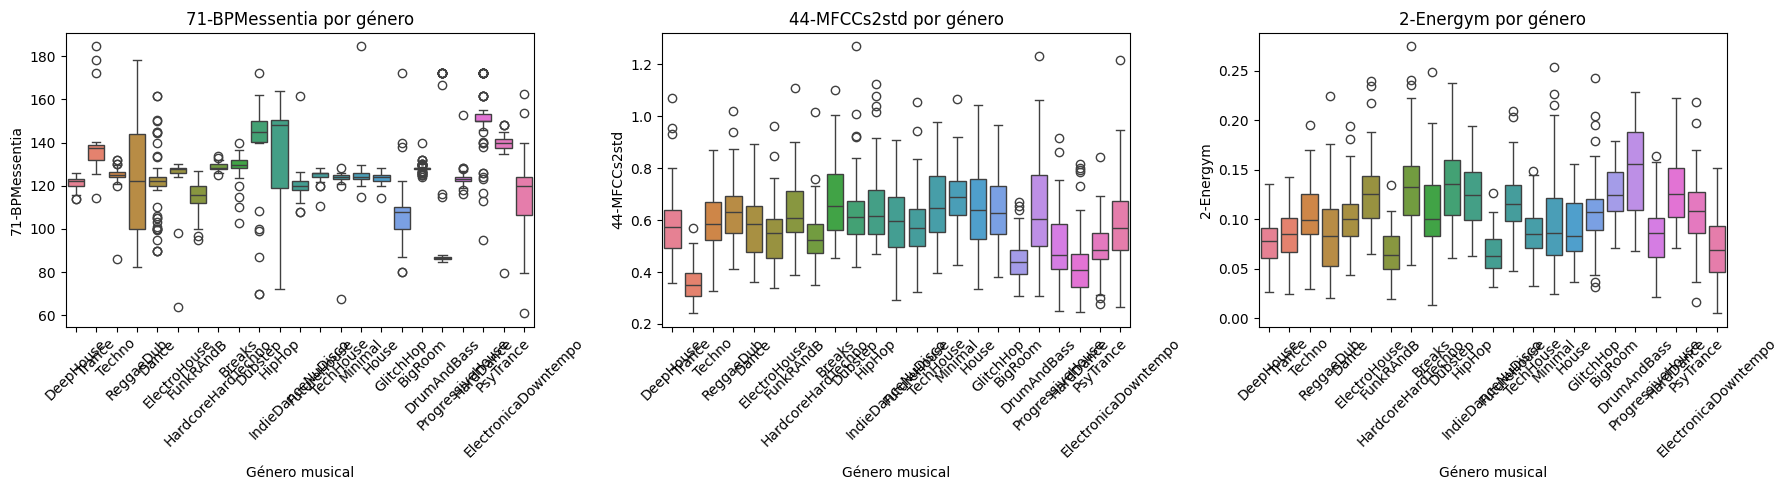

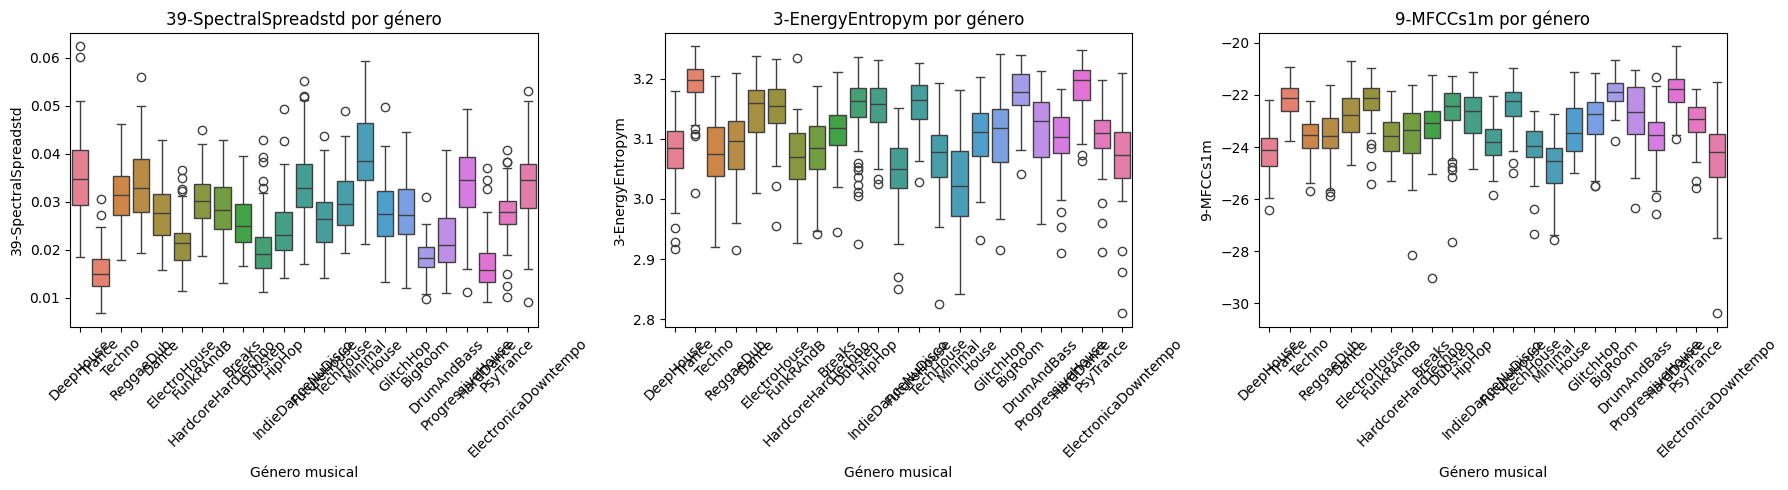

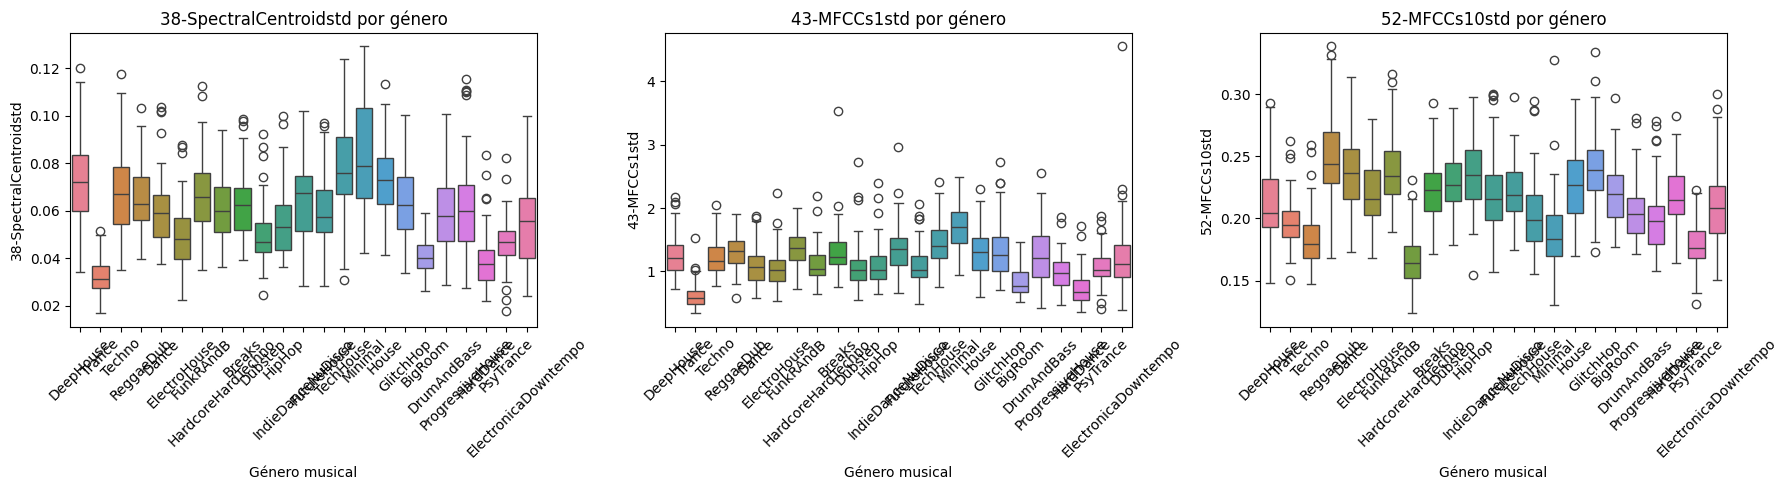

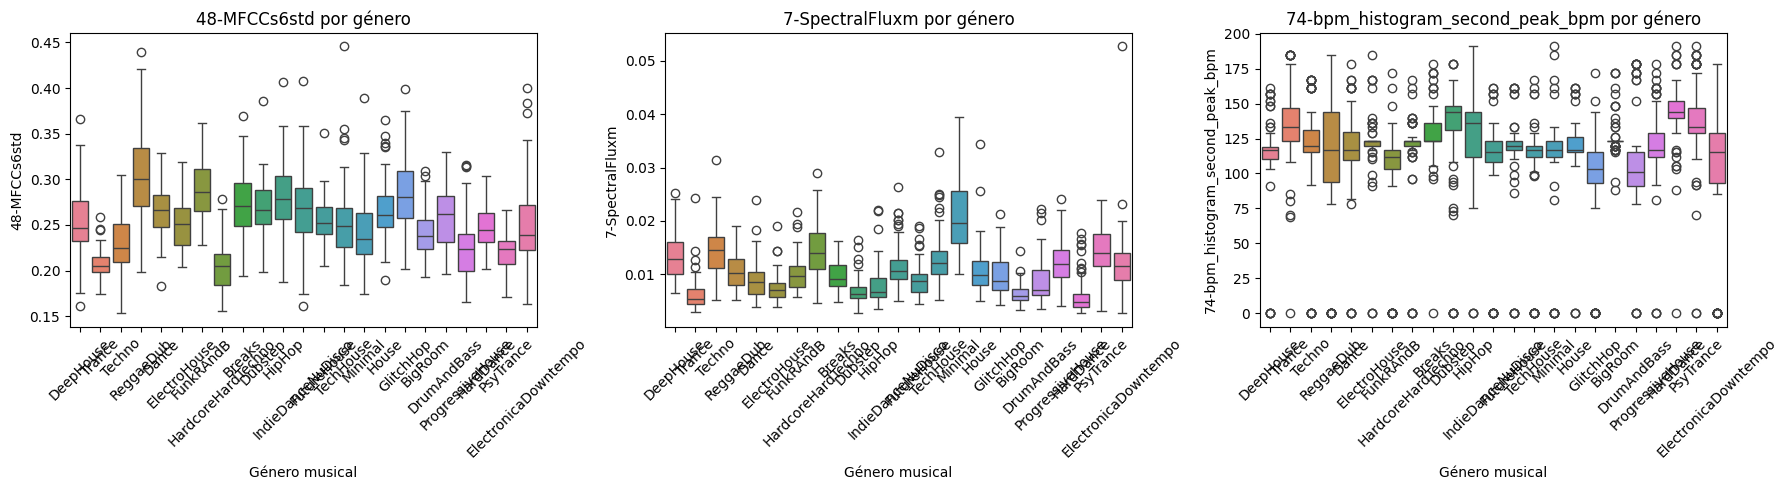

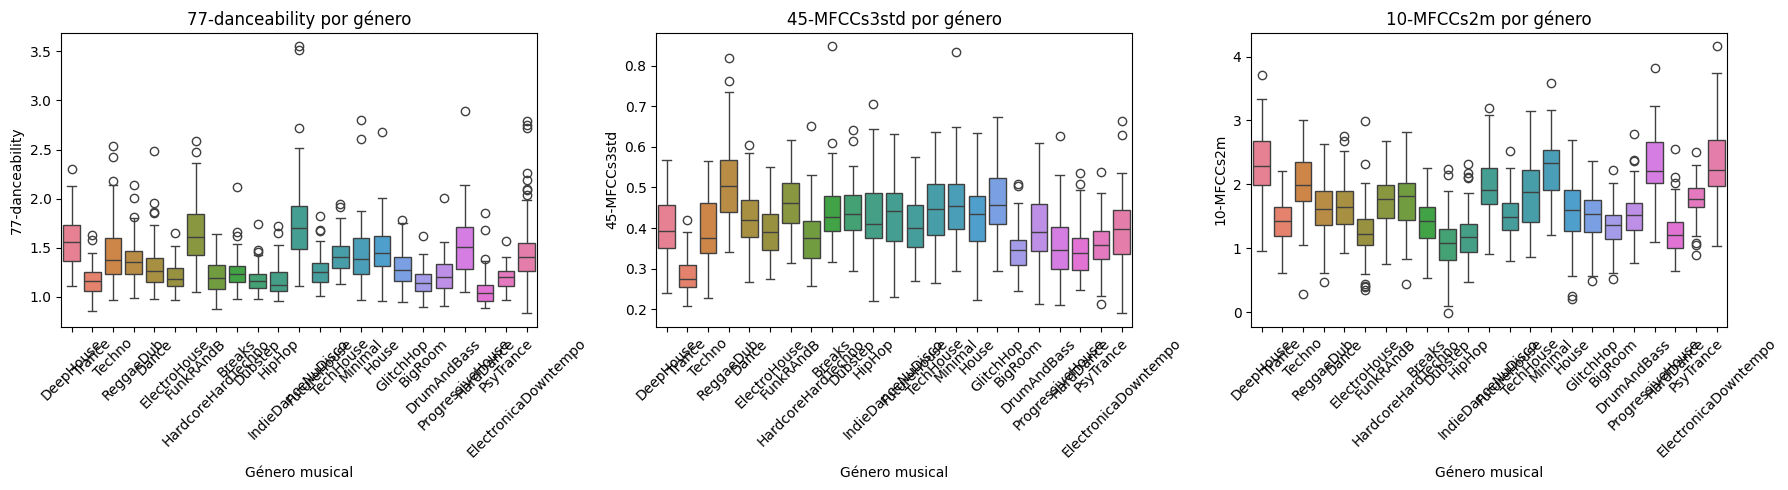

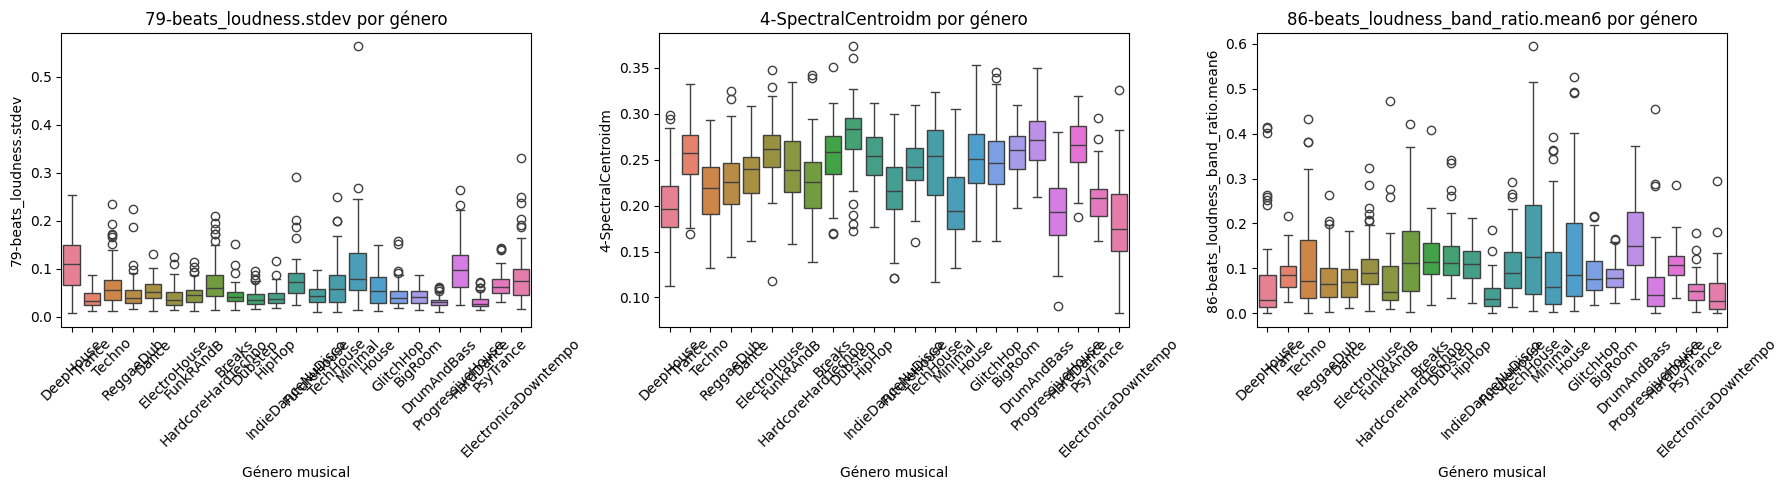

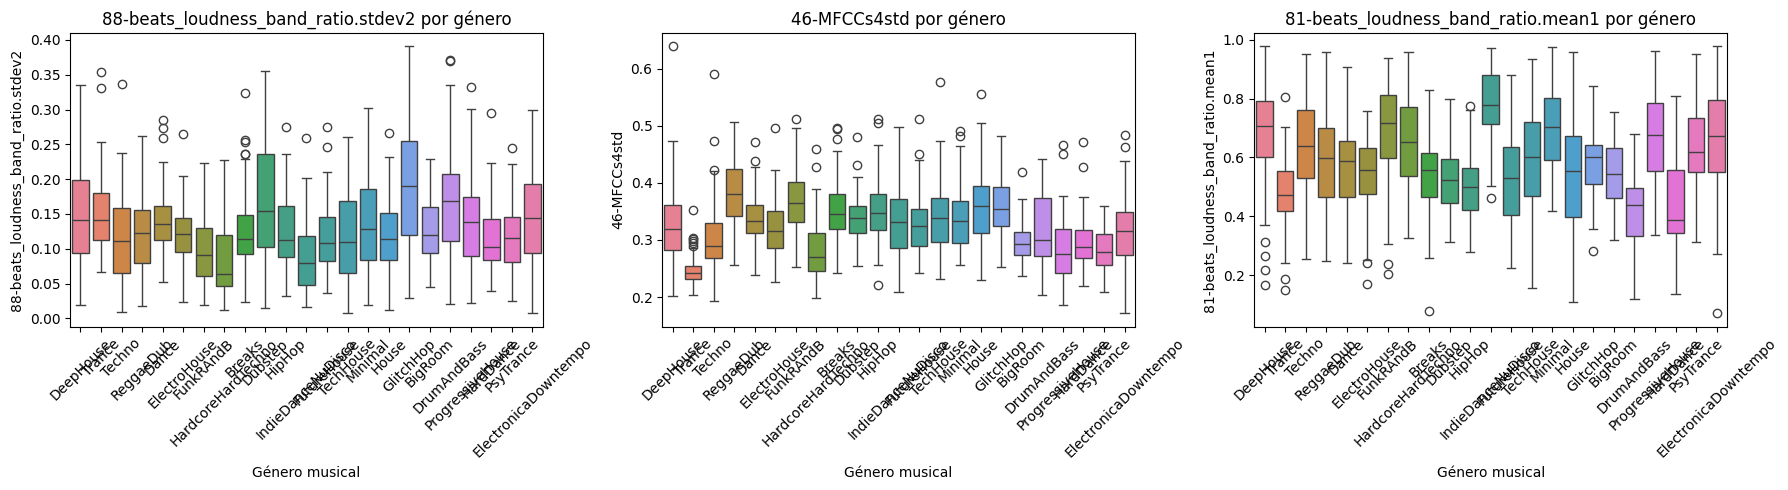

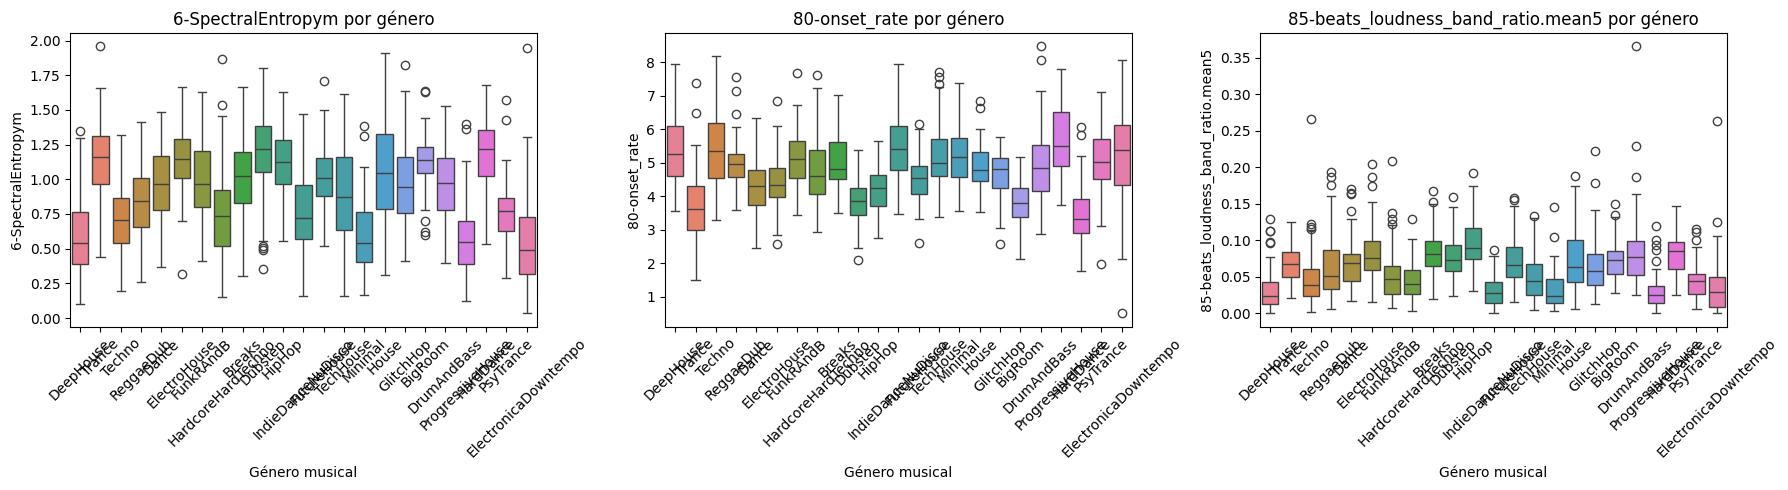

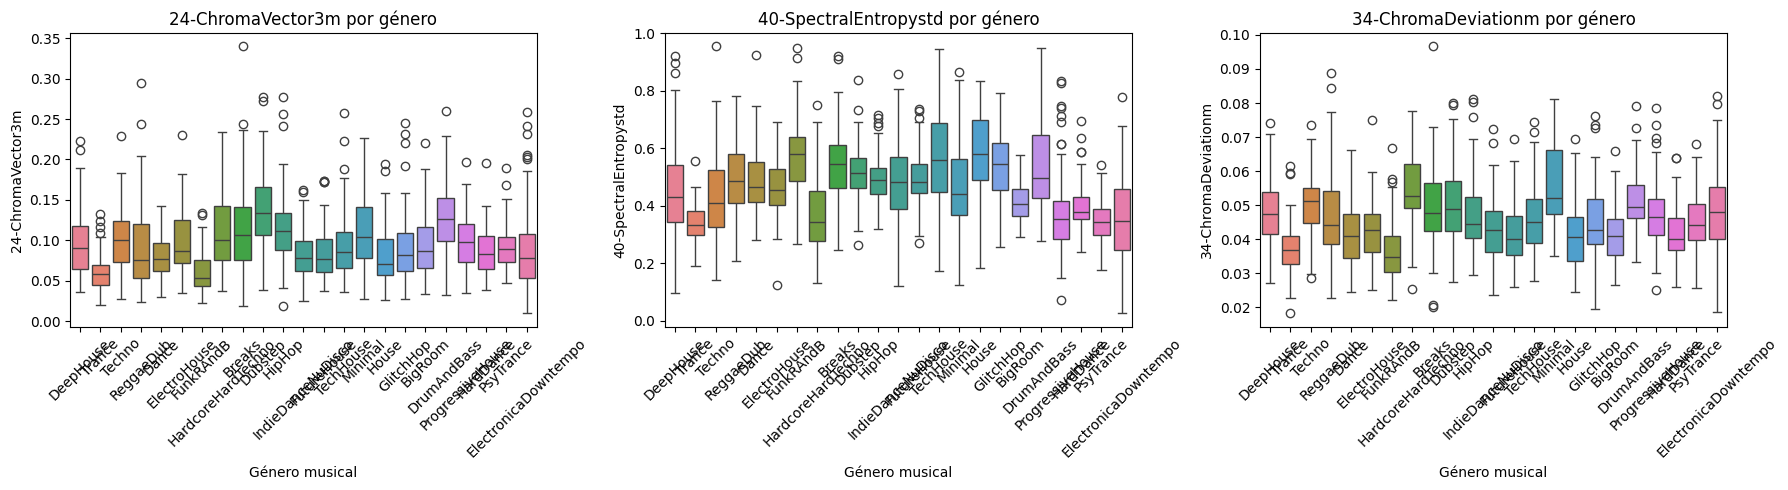

In [107]:

# Dividir en grupos de 3
feature_groups = [feat_selec_imp_col[i:i + 3] for i in range(0, len(feat_selec_imp_col), 3)]

# Graficar los boxplots por grupo
for group in feature_groups:
    fig, axes = plt.subplots(1, len(group), figsize=(6 * len(group), 5))
    if len(group) == 1:
        axes = [axes]
    for ax, feature in zip(axes, group):
        sns.boxplot(x=y, y=train_set[feature], ax=ax, hue = y)
        ax.set_title(f'{feature} por género')
        ax.set_xlabel('Género musical')
        ax.set_ylabel(feature)
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

# 7. EDA

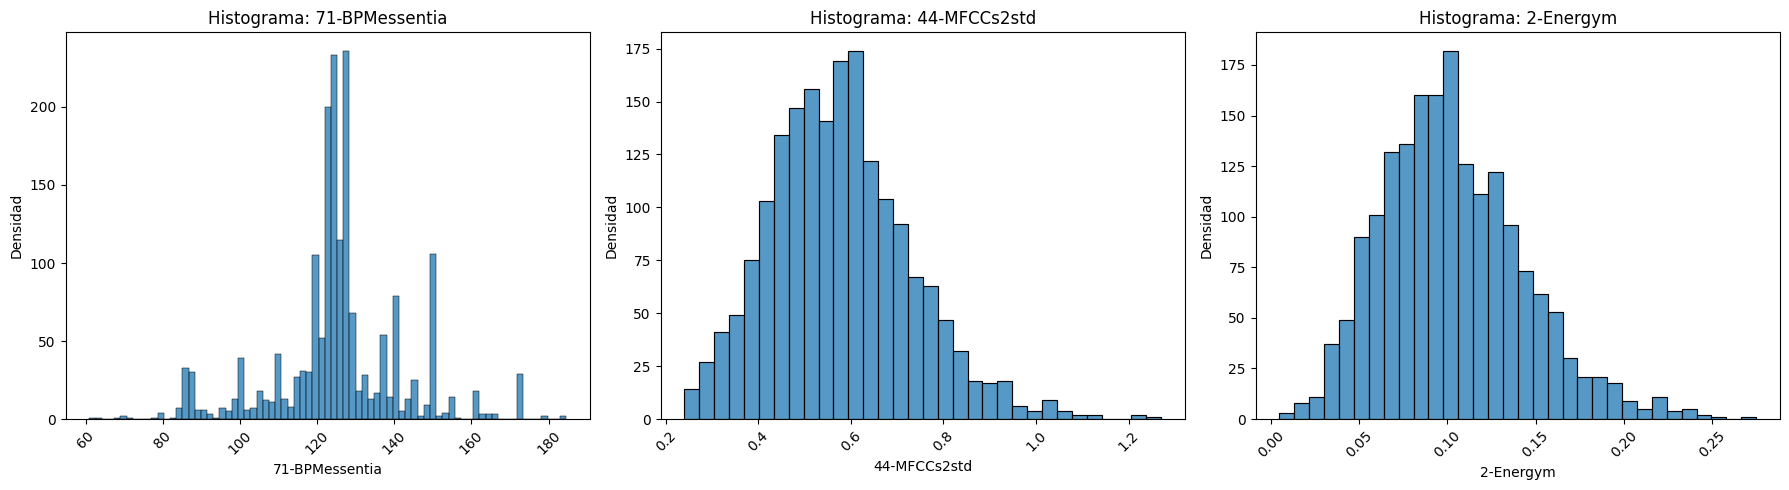

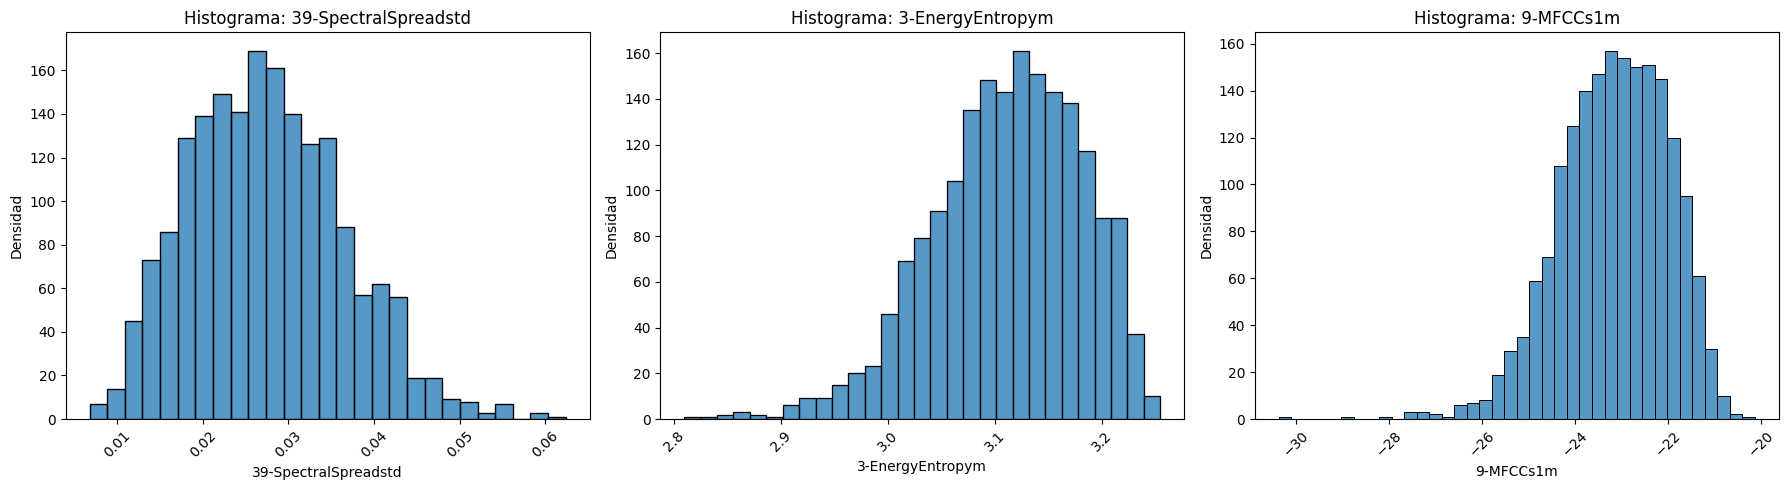

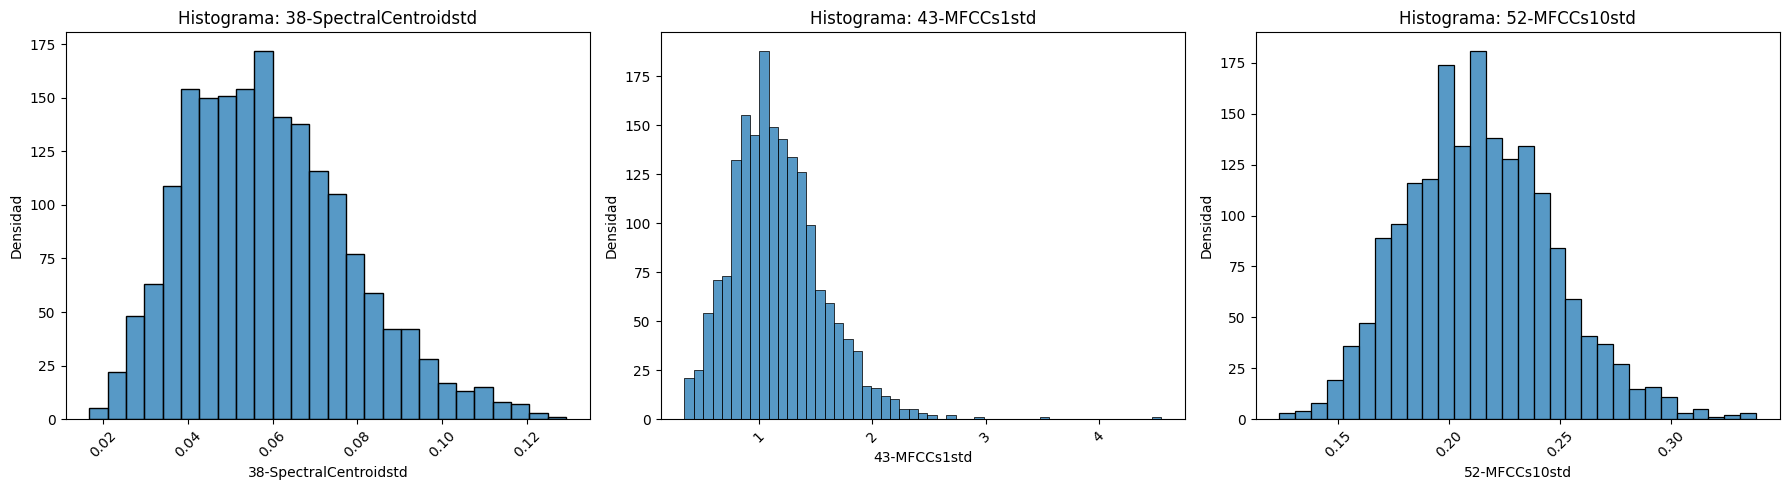

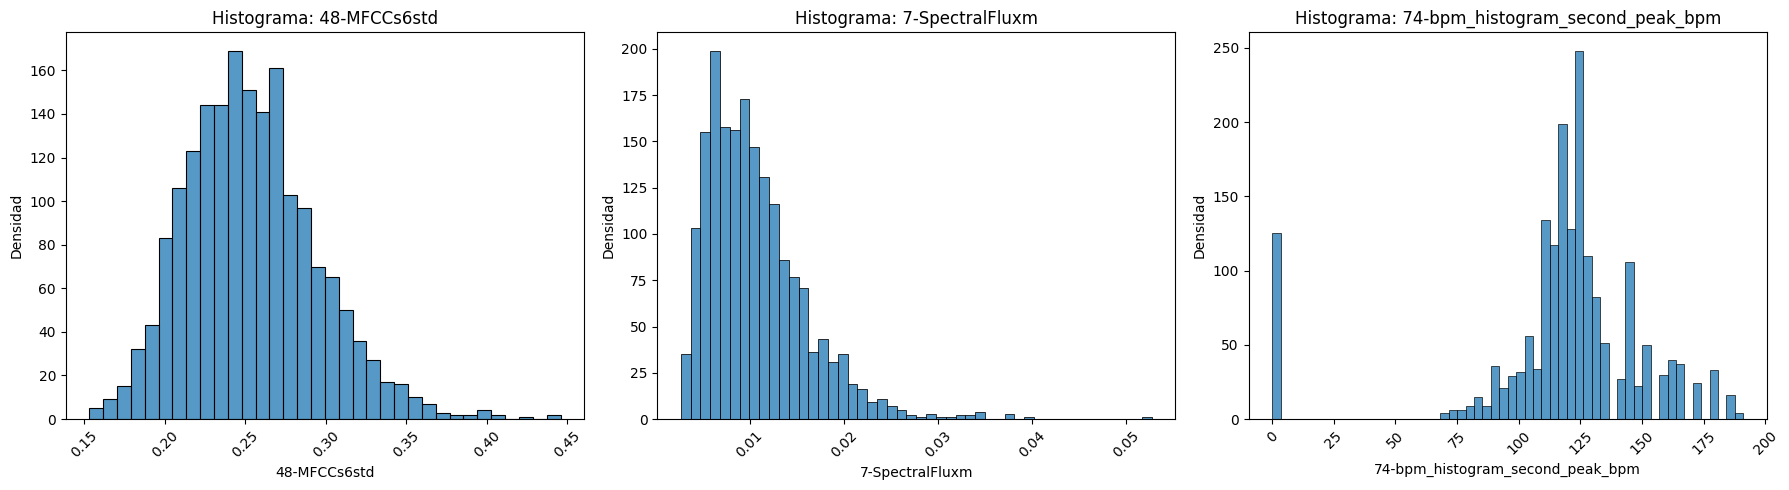

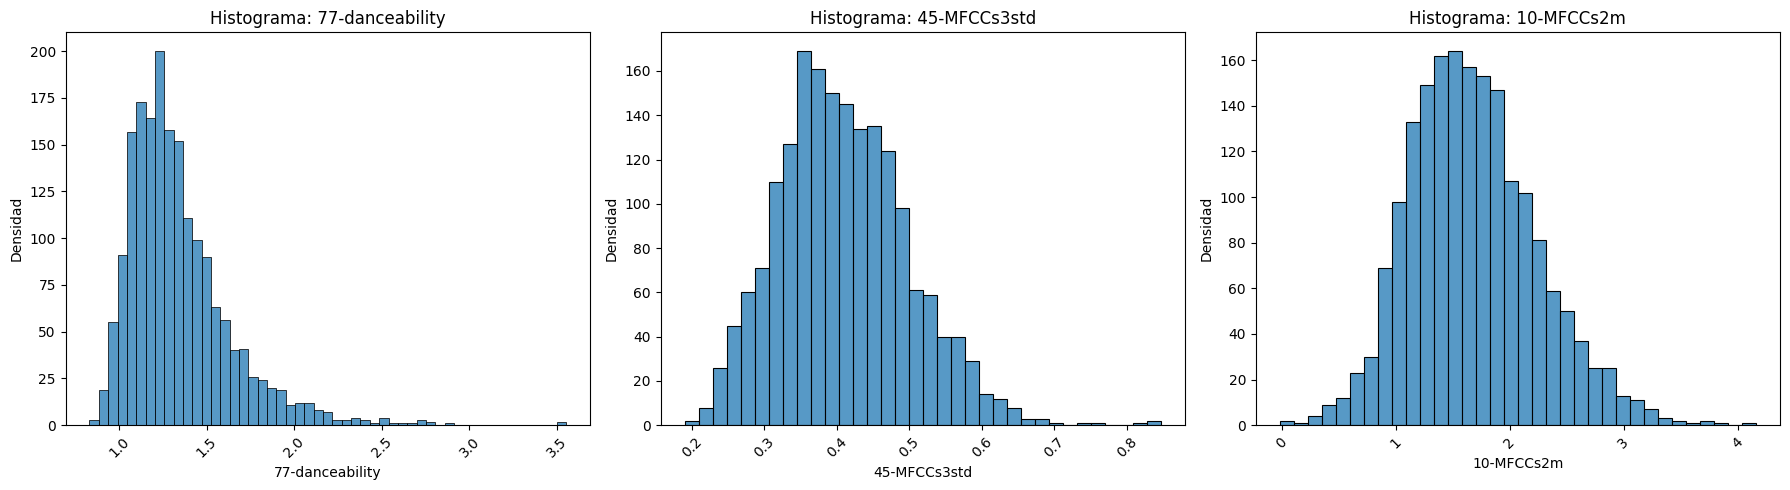

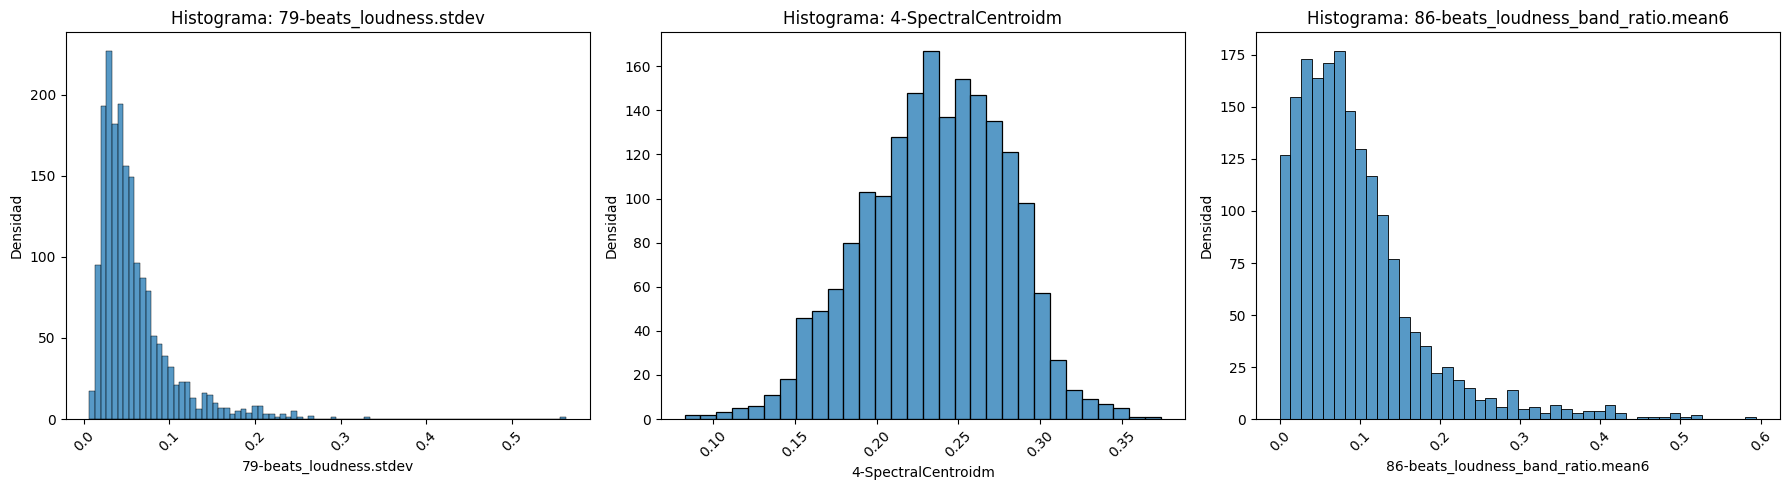

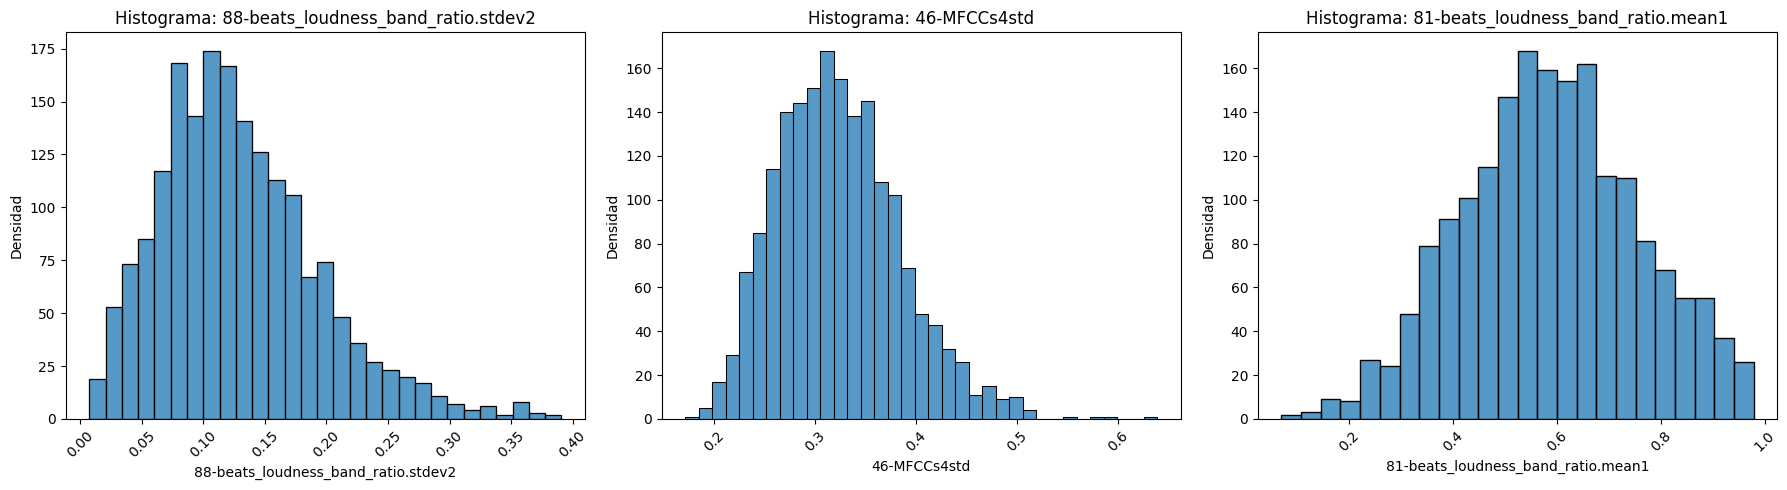

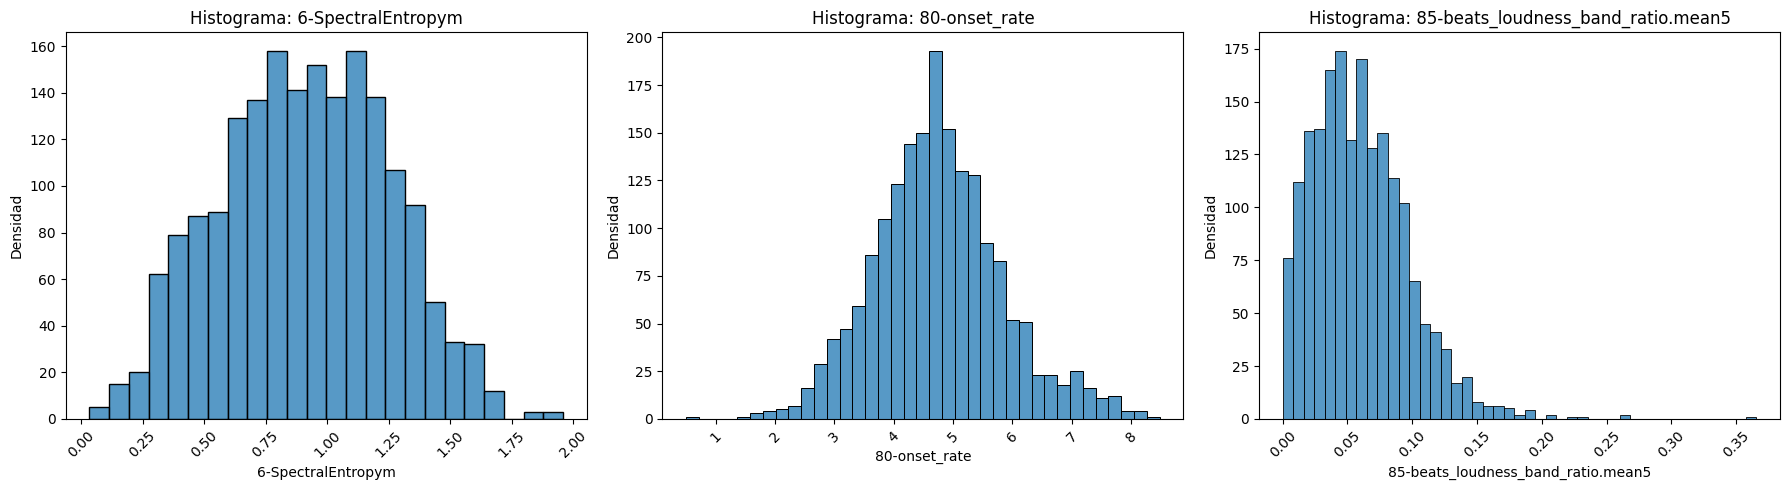

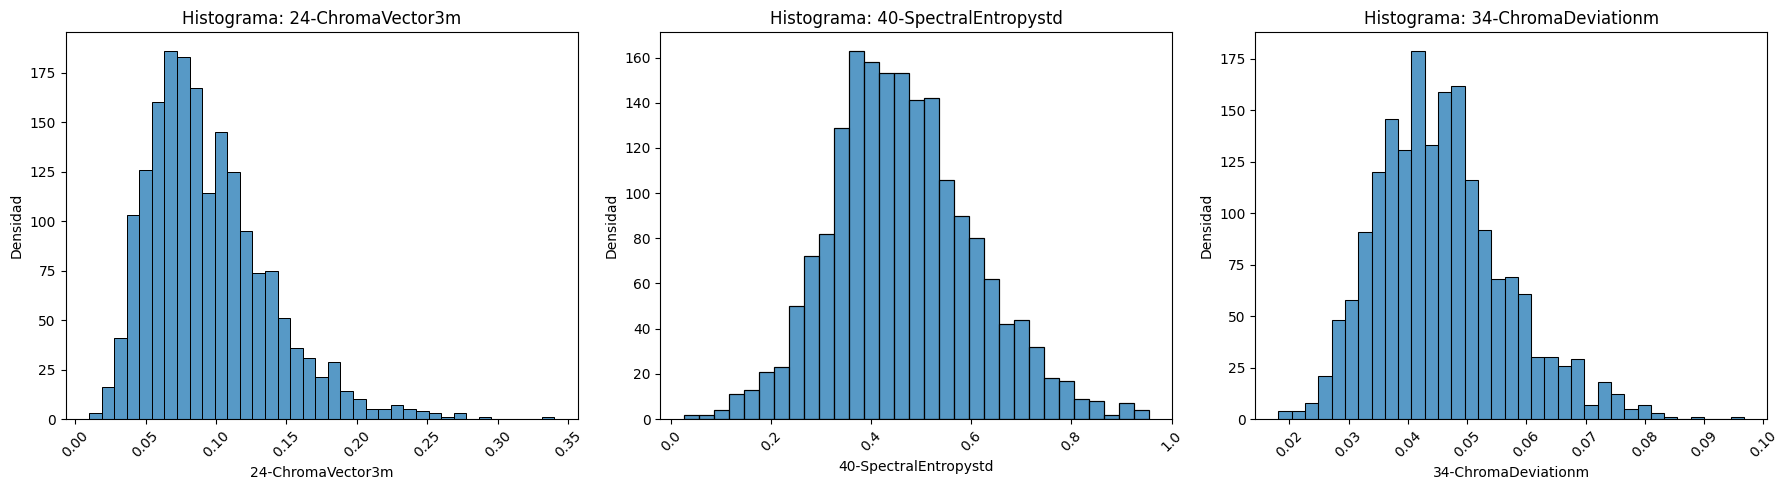

In [108]:
# Dividir las variables en grupos de 3
feature_groups = [feat_selec_imp_col[i:i + 3] for i in range(0, len(feat_selec_imp_col), 3)]

# Crear los histogramas
for group in feature_groups:
    fig, axes = plt.subplots(1, len(group), figsize=(6 * len(group), 5))
    if len(group) == 1:
        axes = [axes]
    for ax, feature in zip(axes, group):
        sns.histplot(data=train_set, x=feature, common_norm=False, ax=ax)
        ax.set_title(f'Histograma: {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Densidad')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()